In [1]:
import random
import scipy
from autograd import grad, jacobian
import autograd.numpy as np
import matplotlib.pyplot as plt
import copy
%matplotlib inline
from IPython import display
from time import sleep
import time
cmap = dict()
cmap[0] = "V"
cmap[1] = "C"
cmap[2] = "+"
cmap[3] = "-"
cmap[4] = "*"
cmap[5] = "/"
cmap[6] = "^"

emap = dict()
for (k,v) in cmap.items():
  emap[v] = k

def mean(x):
  return sum(x) / len(x)
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/synth513/

Mounted at /content/drive
/content/drive/MyDrive/synth513


## A small DSL for physics:

In [2]:
class PhyExpr:
  # pi, g, 1/2, 2, c, G, k
  constants = [3.14, 9.8, 0.5, 2, 3, 6.67, 8.99]
  phymap = emap
  nummap = cmap
  def __init__(self, expr, child1 = None, child2 = None, parent = None):
    self.parent = parent
    self.expr = expr
    if child1 is not None:
      self.child1 = child1
      self.child1.parent = self
    if child2 is not None:
      self.child2 = child2
      self.child2.parent = self
    self.vars = None
    self.value = None
    self.desc = None
    # self.cidx = None
    self.vidx = None
    if expr != "V" and "V" in expr:
      self.vidx = int(expr[1:])
    if expr != "C" and "C" in expr:
      self.value = float(expr[1:])
  def getnodes(self):
    if("V" in self.expr or "C" in self.expr):
      return [self.expr[0]]
    else:
      return [self.expr[0]] + self.child1.getnodes() + self.child2.getnodes()

  def getroot(self):
    return self.expr[0]
  
  def getedges(self):
    leftlist = []
    rightlist = []
    if(not("V" in self.child1.expr or "C" in self.child1.expr)):
      leftlist = self.child1.getedges()
    if(not("V" in self.child2.expr or "C" in self.child2.expr)):
      rightlist = self.child2.getedges()
    
    return [(self.expr[0], self.child1.expr[0]), (self.expr[0], self.child2.expr[0])] +leftlist+rightlist
    # if("V" in self.expr or "C" in self.expr):
    #   return [(self.parent.expr[0], self.expr[0])]
    # else:
    #   return self.child1.getedges() + self.child2.getedges()

  def setchild1(self, node):
    self.child1 = node
  def setchild2(self, node):
    self.child2 = node
  def setvalue(self, val):
    self.value = val
  def setdesc(self, desc):
    self.desc = desc

  def varnum(self):
    return len(self.getvars())
  
  def getvars(self):
    if self.vars is not None:
      return self.vars
    if "V" in self.expr or "C" in self.expr:
      if(self.expr == "V" or self.expr == "C"):
        self.vars = [self]
      else:
        self.vars = []
    else:
      self.vars = self.child1.getvars() + self.child2.getvars()
    return self.vars
  
  def setvalues(self, inputs):
    vars = self.getvars()
    for i, input in enumerate(inputs):
      vars[i].setvalue(input)
  
  # Compute the expression against a particular 
  # assignment of vars/constants
  def compute(self, inputs = None):
    # if(inputs is not None):
    #   self.setvalues(inputs)
    return self.eval(inputs, symbolic = False)
  
  def getprob(self, prob):
    p = prob[PhyExpr.phymap[self.expr[0]]]
    if "V" in self.expr or "C" in self.expr:
      return p
    else:
      return p * self.child1.getprob(prob) * self.child2.getprob(prob)

  # If symbolic = True, we eval the expression symbolically
  # against all possible assignment of variables/constants
  def eval(self, inputs, symbolic = True):
    res = []
    if "V" in self.expr:
      if self.expr == "V":
        if symbolic:
          for input in inputs:
            res.append(input)
        else:
          if self.value is None:
            raise Exception(f"Not symbolic and {self.expr} in {self.parent.tostr()} has not been assigned!")
          return [self.value]
      else:
        # print(self.expr, inputs)
        self.value = inputs[self.vidx]
        self.desc = self.expr
        return [self.value]
    elif "C" in self.expr:
      if self.expr == "C" and symbolic:
          for constant in PhyExpr.constants:
            res.append(constant)
      else:
        if self.value is None:
          raise Exception(f"Not symbolic and {self.expr} in {self.parent.tostr()} has not been assigned!")
        return [self.value] 

    else:
      rl1 = self.child1.eval(inputs, symbolic)
      rl2 = self.child2.eval(inputs, symbolic)
      # print(self.tostr(), self.child1.tostr(), rl1)
      if(self.expr == "+"):
        res = [x + y for x in rl1 for y in rl2]
      elif(self.expr == "*"):
        res = [x * y for x in rl1 for y in rl2]
      elif(self.expr == "-"):
        res = [x - y for x in rl1 for y in rl2]
      elif(self.expr == "/"):
        res = [x / y for x in rl1 for y in rl2]
      elif(self.expr == "^"):
        # print(rl1,rl2)
        x = rl1[0]
        y=rl2[0]
        if(y > 2):
          print(x,y)
        res = [x ** y for x in rl1 for y in rl2]
    return res
  
  def tostr(self, val = False):
    if "V" in self.expr or "C" in self.expr:
      if val:
        return self.desc
      else:
        return self.expr
    else:
      rl1 = self.child1.tostr(val)
      rl2 = self.child2.tostr(val)
      return f"({self.expr} {rl1} {rl2})"

## Search solutions for symbolic DSL snippets that simulate a "solver"

In [3]:
def searchSol(expr, manyinputs, outputs):
  vars = expr.getvars()
  numv = len(vars)
  numparam = len(manyinputs[0])
  idxs = [0] * numv
  limits = [numparam if "V" in var.expr else len(PhyExpr.constants) for var in vars]
  # Randomly shuffle variable orders
  varnum = list(range(numparam))
  random.shuffle(varnum)
  # print(varnum)
  while True:
    matched = True
    for j, inputs in enumerate(manyinputs):
      output = outputs[j]  
      for i,var in enumerate(vars):
        if(var.expr == "V"):
          var.setdesc(f"V{varnum[idxs[i]]}")
          var.setvalue(inputs[varnum[idxs[i]]])
        else:
          var.setdesc(var.value)
          var.setvalue(PhyExpr.constants[idxs[i]])
      res = expr.compute(inputs)
      if(abs(res[0] - output) > 1e-9):
        matched = False
        break
      # for i,var in enumerate(vars):
      #   if(var.expr == "V"):
      #     var.setvalue(inputs[idxs[i]])
    if matched:
      print(f"{expr.tostr()} has solution {expr.tostr(val = True)}")
      return True
    
    # Advance assignments
    idx = numv - 1
    while(idx >= 0 and idxs[idx] >= limits[idx] - 1):
      idx -= 1
    if idx < 0:
      break
    idxs[idx] += 1
    for i in range(idx + 1, numv):
      idxs[i] = 0
  print(f"{expr} under {inputs} has no solution for {output}")
  return False

## A small compiler for physics DSL

In [4]:
def compile(func, debug = False):
  res = None
  # print(func)
  if "V" in func[0] or "C" in func[0]:
    return PhyExpr(func)
  lidx = func.find("(")
  ridx = func.rfind(")")
  expr = func[lidx+1:ridx]
  # ops = expr[:]
  # opcode = ops[0]
  idx = expr.find(" ")
  opcode = expr[:idx]
  remain = expr[idx+1:]
  # print(remain)
  op1 = None
  op2 = None
  if debug:
    print(f"{func}: {expr} ----> {remain}")
  if(remain[0] == "("):
    # Find right parenthesis that match
    rpidx = 0
    count = 0
    while rpidx < len(remain):
      if(remain[rpidx] == "("):
        count += 1
      elif (remain[rpidx] == ")"):
        count -= 1
      rpidx += 1
      if count == 0:
        break
    
    op1 = remain[:rpidx]
    op2 = remain[rpidx + 1:]
    # print(idx)
  else:
    idx = remain.find(" ")
    op1 = remain[:idx]
    op2 = remain[idx+1:]
  # print(idx
  # print("["+op1+"]", "["+op2+"]")
  expr1 = compile(op1)
  expr2 = compile(op2)
  return PhyExpr(opcode, expr1, expr2)

# A little test
ex = compile("(* C0.5 (* V0 (* V V1)))").eval([1,2], symbolic=True)
print(ex)
# searchSol(ex, [[1]], [4.9, 19.6])
func = "(+ (* V V) (- (^ V C) V))"
compile(func).eval([2])

[1.0, 2.0]
2 3.14


[10.815240927012887,
 893.4437768152316,
 3.414213562373095,
 6,
 10,
 103.82866992062958,
 510.46335766376245]

## The Physics DSL dataset

In [5]:
phys_dataset = [
    ["(* C0.5 (* V0 (^ V1 C2)))", 2], # v=1/2at^2
    ["(^ (+ (^ V0 C2) (* C2 (* V1 (- V2 V3)))) C0.5)", 4], #v = sqrt(v0^2 + 2a(x-x0))
    ["(^ (+ (V0 C2) (^ V1 C2)) C0.5)", 2], #v = sqrt(vx^2 + vy^2)
    ["(/ (^ V0 C2) V1)", 2], #A_r = v^2/R
    ["(* V0 (^ C3 C2))", 1], #E = mc^2
    ["(/ (+ (* V0 V2) (* V1 V3)) (+ V0 V1))", 4], #X_c = (m1*x1+m2*x2)/(m1+m2)
    ["(/ V0 V1)", 2], #Rho = m/V
    ["(/ V0 V1)", 2], #P = f/S
    ["(* (^ V0 C2) V1)", 2], #P = I^2R
    ["(/ V0 (^ C2 C0.5))", 1], #V_rms = V/sqrt(2)
    ["(* C0.5 (* V0 (^ V1 C2)))", 2], #U = ½ CV^2
    ["(* C0.5 (/ (^ V0 C2) V1))", 2], #U = ½ Q^2/C
    ["(/ C1 V0)", 1], #P = 1/f
    ["(/ V0 C2)", 1], #C = R/2
    ["(/ V0 V1)", 2], #A = F/m
    ["(* V0 V1)", 2], #W = F*d
    ["(* V0 V1)", 2], #P = F*v
    ["(* V0 (* V1 V2))", 3], #F = qvB
    ["(* V0 V1)", 2], #Tau = F*r
    ["(+ V0 (* V1 V2))", 3], #v = v0+a*t
    ["(+ V0 (+ (* V1 V2) (* C0.5 (* V3 (^ V2 C2)))))", 4], #X = x0+v0*t + ½*a*t^2
    ["(* V0 V1)", 2], #P = mv
    ["(* C0.5 (* V0 (^ V1 C2)))", 2], #K = 1/2mv^2
    ["(* C0.5 (* V0 (^ V1 C2)))", 2], #K = ½ Iw^2
    ["(* V0 V1)", 2], #E = pJ
    ["(* V0 V1)", 2], #F = kx
    ["(/ (* C2 C3.14) V0)", 1], #T = 2pi/w
    ["(* (* C2 C3.14) (^ (/ V0 V1) C0.5))", 2], #Ts = 2pi(m/k) ^(1/2)
    ["(* (* C2 C3.14) (^ (/ V0 C9.8) C0.5))", 1], #Tp = 2pi(l/g)^(1/2)
    ["(/ (* C6.67 (* V0 V1)) (^ V2 C2))", 3], #F = Gm1m2/(r^2)
    ["(/ (* C8.99 (* V0 V1)) (^ V2 C2))", 3], #F = kq1q2/(r^2)
    ["(* V0 V1)", 2], #V = R*I
    ["(* V0 V1)", 2], #P = V*I
    ["(* V0 (* V1 C9.8))", 2], #E = mhg
    ["(/ C1 V0)", 1], #f = 1/T
    ["(/ V0 V1)", 2], #C = V/Q
    ["(+ V0 V1)", 2], #Rs = R1+R2
    ["(+ V0 V1)", 2], #Cp = C1+C2
    ["(/ C1 (+ (/ C1 V0) (/ C1 V1)))", 2], #Rp = 1/(1/R1 + 1/R2)
    ["(/ C1 (+ (/ C1 V0) (/ C1 V1)))", 2], #Cs = 1/(1/C1 + 1/C2)
    ["(* C3.14 (^ V0 C2))", 1], #A = pi r^2
    ["(^ (+ (^ V0 C2) (^ V1 C2)) C0.5)", 2], #c = (a^2 + b^2)^(½)
]
np.random.seed(142)
phys_codes = [data[0] for data in phys_dataset]
phys_compiled = [compile(code) for code in phys_codes]
all_phys = np.array(phys_compiled)
num_fold = 5
num_data = len(all_phys)
idx_list = list(range(num_data))
np.random.shuffle(idx_list)
fold_len = (num_data - 1) // num_fold + 1

fold_list = []
for i in range(num_fold):
  train_list = idx_list[fold_len:] if i == 0 else idx_list[:(i*fold_len)] + idx_list[(i+1)*fold_len:]
  test_list = idx_list[i * fold_len: (i+1) * fold_len]
  fold_list.append((train_list, test_list))
codetrain_datas = []
codetest_datas = []
for fidx in range(num_fold):
  codetrain_datas.append([phys_compiled[idx] for idx in fold_list[fidx][0]])
  codetest_datas.append([phys_compiled[idx] for idx in fold_list[fidx][1]])

In [6]:
# If K = -1, we return the limit as K -> inf
def depth_normalizer(theta, K = -1):
  if K == -1:
    # pt = theta[0] + theta[1]
    return (1-(1- 4*(sum(theta[2:]))*sum(theta[:2]))**(0.5))/ (2*sum(theta[2:]))
  p_ged = [sum(theta[:2])] + [0.0] * K
  # p_ged[0] = p_stop
  for i in range(1, K + 1):
    p_ged[i] = sum(theta[:2]) +sum(theta[2:]) * (p_ged[i - 1] ** 2)
    # print(p_ged[i])
  return p_ged[K]

def approximate_prob(data, theta, depth_norm = False, K = -1):
  res = []
  test_data = data
  for prog in test_data:
    # prog = compile(code)
    prob = 1.0
    for opcode in prog.getnodes():
      prob *= theta[PhyExpr.phymap[opcode]]
    if depth_norm:
      prob = prob / depth_normalizer(theta, K)
    res.append(prob)
  return res

In [10]:
# test_base_probs = [None] * num_fold
# train_base_probs = [None] * num_fold
Kval = 6
base_theta = np.ones(7)/7.0
base_probs = approximate_prob(phys_compiled,base_theta,True, K=Kval)
test_mh_probs = [None] * num_fold
train_mh_probs = [None] * num_fold
test_hmc_probs = [None] * num_fold
train_hmc_probs = [None] * num_fold
test_svi_probs = [None] * num_fold
train_svi_probs = [None] * num_fold
# mh_trained_thetas = [None] * num_fold
# hmc_trained_thetas = [None] * num_fold
# svi_trained_thetas = [None] * num_fold

In [ ]:
mh_times = [None] * num_fold
hmc_times = [None] * num_fold
svi_times = [None] * num_fold

In [ ]:
mh_equaltrained_thetas = [None] * num_fold
hmc_equaltrained_thetas = [None] * num_fold
svi_equaltrained_thetas = [None] * num_fold

In [15]:
mh_equaltrained_thetas = np.load("mh_equaltrained_thetas.npy")
hmc_equaltrained_thetas = np.load("hmc_equaltrained_thetas.npy")
svi_equaltrained_thetas = np.load("svi_equaltrained_thetas.npy")

In [99]:
mh_trained_thetas = np.load("mh_thetas.npy")
hmc_trained_thetas = np.load("hmc_trained_thetas.npy")
svi_trained_thetas = np.load("svi_trained_thetas.npy")

## Generate data

In [ ]:
sample_per_prog = 200
maximum = 1
minimum = 0
prog_data = []
for i, program in enumerate(phys_compiled):
  num_params = phys_dataset[i][1]
  # if
  # print(program.tostr())
  inputs = np.random.rand(sample_per_prog, num_params) * ((maximum - minimum)+  minimum)
  # if(i == 1):
    # print(inputs)
  # print(program.tostr())
  outputs = []
  for j in range(sample_per_prog):
    if i == 1 and inputs[j][2] < inputs[j][3]:
      tmp = inputs[j][2]
      inputs[j][2] = inputs[j][3]
      inputs[j][3] = tmp
    outputs.append(program.eval(inputs[j]))
  outputs = np.array(outputs)
  # inputs = np.concatenate(inputs, np.zeros(sample_per_prog, 4-num_params), axis = 1)
  inputs = np.hstack([inputs, np.zeros([sample_per_prog, 4-num_params])])
  data = np.hstack([inputs, outputs])
  # print(np.mean(data, axis = 1).shape)
  data -= np.mean(data, axis = 1).reshape(-1,1)
  data = data/(np.std(data, axis = 1).reshape(-1,1))
  data= np.hstack([data, np.zeros([sample_per_prog, 1])+ i])
  # if(i == len(phys_compiled) - 1):
  # print(np.sum(np.isnan(inputs)))
  prog_data.append(data)
prog_data = np.vstack(prog_data)

In [ ]:
# np.save("physics_data.npy", prog_data)
physicsio_data = np.load("physics_data.npy")

In [ ]:
comb_num = 8
combined_array = []
for i in range(0, physicsio_data.shape[0], comb_num):
  dat = np.concatenate(physicsio_data[i:i+comb_num][:,:-1])
  dat = np.concatenate([dat, physicsio_data[i][-1].reshape(-1)])
  combined_array.append(dat)
physicsio_data_combined = np.array(combined_array)

In [ ]:
sample_per_prog = 200
sample_per_prog_multi = sample_per_prog // comb_num
# np.random.seed(42)
# C = 5
# phys_codes = [data[0] for data in physio_data]
# phys_compiled = [compile(code) for code in phys_codes]
num_samples = physicsio_data.shape[0]
# all_data = np.array(phys_compiled)
num_fold = num_fold
# num_data = 
# ioidx_list = list(range(num_samples))
# np.random.shuffle(ioidx_list)
# fold_len = (num_samples - 1) // num_fold + 1

iofold_list = []
iofold_list_multi = []
# for i in range(num_fold):
#   iotrain_list = ioidx_list[fold_len:] if i == 0 else ioidx_list[:(i*fold_len)] + ioidx_list[(i+1)*fold_len:]
#   iotest_list = ioidx_list[i * fold_len: (i+1) * fold_len]
#   iofold_list.append((iotrain_list, iotest_list))
for train_list, test_list in fold_list:
  iotrain_list = []
  iotest_list = [] 
  iotrain_list_multi = []
  iotest_list_multi = []
  for idx in train_list:
    iotrain_list += list(range(idx * sample_per_prog, (idx + 1) * sample_per_prog))
    iotrain_list_multi += list(range(idx * sample_per_prog_multi, (idx + 1) * sample_per_prog_multi))
  for idx in test_list:
    iotest_list += list(range(idx * sample_per_prog, (idx + 1) * sample_per_prog))
    iotest_list_multi += list(range(idx * sample_per_prog_multi, (idx + 1) * sample_per_prog_multi))
  iofold_list.append((iotrain_list,iotest_list))
  iofold_list_multi.append((iotrain_list_multi,iotest_list_multi))

## The depth normalizer that limits search to depth = K. If K = -1, we return the limit of the normalizer as K -> inf.

## Auxilary functions for log of values

In [7]:
def logbeta(alpha):
  res = np.sum(scipy.special.loggamma(alpha))-scipy.special.loggamma(np.sum(alpha))
  return res

def logdirichlet(theta, alpha):
  # print(alpha)
  # print(logbeta(alpha))
  lb = logbeta(alpha)
  res = np.sum((alpha - 1.0) * np.log(theta)) - lb
  
  return res

def log_joint_withoutnorm(data, theta, eta = np.array([1.0]*7), K = -1):
  log_theta = np.log(theta)
  res = 0
  for prog in data:
    for opcode in prog.getnodes():
      res += log_theta[PhyExpr.phymap[opcode]]
    res -= np.log(depth_normalizer(theta, K))
  res += logdirichlet(theta, eta)
  return res

## Metropolis-Hasting with Dirichlet proposal

rate: 0.00275
[0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714]
[0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714]


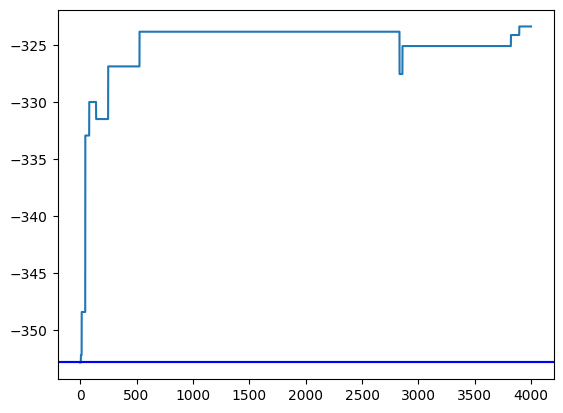

KeyboardInterrupt: ignored

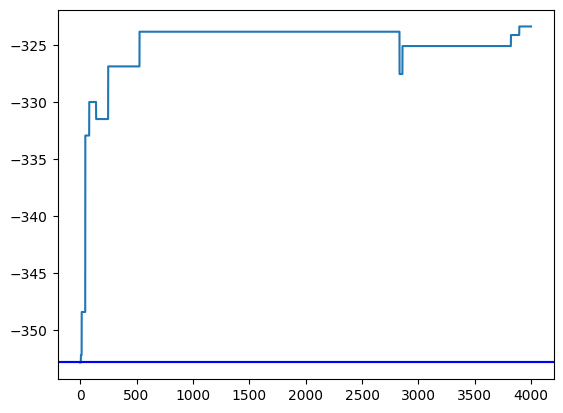

In [8]:

# all_data = np.array(phys_compiled)
# all_data = train_data
fidx = 0
codetrain_data = codetrain_datas[fidx]
codetest_data = codetest_datas[fidx]
Kval = 6
iterations = 200000
warmups = 50000

samples = []
lls = []
step = 1000
# theta = np.random.rand(7)
# theta = theta / sum(theta)

theta = np.array([1.0/7] * 7)
original_theta = copy.deepcopy(theta)

mhtimerec = []
mhthetarec = []
mhexpthetarec = []

exp_theta = copy.deepcopy(theta)
alpha = 10
epsilon = 0
# constant_alpha = np.array([0.5] * 7)

changed = False
new_times = 0
ll_of_ori = np.sum(np.log(approximate_prob(codetrain_data, original_theta, True, K=Kval)))

start_time = time.time()
for iter in range(1, iterations + 1):
  if(iter > warmups):
    # samples.append(theta)
    # print(theta, exp_theta)
    exp_theta = (exp_theta * (iter - warmups) + theta) / (iter-warmups + 1)
    mhtimerec.append(time.time()-start_time)
    mhexpthetarec.append(exp_theta)
  curr_ll = np.sum(np.log(approximate_prob(codetrain_data, theta, True, K=Kval)))
  lls.append(curr_ll)
  # plt.figure()
  # plt.plot(iter, curr_ll)
  # plt.pause(1)

  alpha_old = theta * alpha + epsilon
  theta_new = np.random.dirichlet(alpha_old)
  # theta_new = np.random.dirichlet(constant_alpha)
  alpha_new = theta_new * alpha + epsilon
  logqyx = logdirichlet(theta_new, alpha_old)
  logqxy = logdirichlet(theta, alpha_new)
  # logqyx = logdirichlet(theta_new, constant_alpha)
  # logqxy = logdirichlet(theta, constant_alpha)
  logpix = log_joint_withoutnorm(codetrain_data, theta, K = Kval)  
  logpiy = log_joint_withoutnorm(codetrain_data, theta_new, K = Kval)
  # print(logqyx, logqxy, logpix, logpiy)
  acceptance = np.exp((logpiy+logqxy) - (logpix + logqyx))
  if(acceptance > 1):
    # print(iter, acceptance)
    theta = theta_new
    changed  = True
  else:
    coin = np.random.rand(1)[0]
    if(coin < acceptance):
      # print(iter, coin, acceptance)
      theta = theta_new
      changed = True
    else:
      changed = False
  if changed:
    new_times += 1
  # mhthetarec.append(theta)
  if(iter% step == 0):
    # mhtimerec.append(time.time() - start_time)
    # mhexpthetarec.append(np.mean(mhthetarec))
    display.clear_output(wait=True)
    print(f"rate: {new_times / iter}")
    print(original_theta)
    print(exp_theta)
    
    ll_of_exp = np.sum(np.log(approximate_prob(codetrain_data, exp_theta, True, K = Kval)))
    plt.clf()
    plt.plot(lls)

    plt.axhline(y = ll_of_ori, color = 'g', linestyle = '-')
    plt.axhline(y = ll_of_exp, color = 'b', linestyle = '-')
    display.display(plt.gcf())
    
    sleep(0.001)
  #   print(f"Iter {iter}")
  #   print(acceptance)
mhelapse = time.time()-start_time
print(mhelapse)
mhtheta = exp_theta
# mh_times[fidx] = mhelapse

In [ ]:
mh_trained_thetas[fidx] = mhtheta
print(mh_trained_thetas)

[array([0.30489742, 0.18516208, 0.06928556, 0.01073775, 0.18664549,
       0.13032374, 0.11294796]), array([0.30142644, 0.17820539, 0.07327232, 0.00869194, 0.22713793,
       0.11563743, 0.09562854]), array([0.30614727, 0.16775545, 0.05343803, 0.01382522, 0.23364273,
       0.12440594, 0.10078537]), array([0.3221967 , 0.16946591, 0.06578317, 0.0139225 , 0.19782674,
       0.10124613, 0.12955885]), array([0.28493047, 0.17375046, 0.06545419, 0.01087699, 0.21413697,
       0.1222619 , 0.12858901])]


In [ ]:
print(mh_times)

[801.9107587337494, 801.6393880844116, 800.765542268753, 799.4305534362793, 862.5733885765076]


In [ ]:
np.save("mh_thetas.npy", np.array(mh_trained_thetas))

In [ ]:
np.save("mhtimerec.npy", np.array(mhtimerec))
np.save("mhexpthetarec.npy", np.array(mhexpthetarec))

## Auxilaries for reparameterized HMC

In [9]:
def grad_depth_normalizer(theta, K = -1):
  if K == -1:
    raise Exception("limit for HMC not implemented!")
    # pt = theta[0] + theta[1]
    # return (1-(1- 4*(1-pt)*pt)**(0.5))/ (2*(1-pt))
  p_stop = theta[PhyExpr.phymap["V"]] + theta[PhyExpr.phymap["C"]]
  p_cont = 1 - p_stop
  p_ged = [p_stop] + [0.0] * (K)
  # p_ged[0] = p_stop
  g_ged = [[0.0] * len(theta)]* (K + 1)
  g_ged[0] = [1.0]*2 + [0.0] * 5
  
  for i in range(1, K + 1):
    p_ged[i] = p_stop + p_cont * (p_ged[i - 1] ** 2)
    for j in range(7):
      if j < 2:
        g_ged[i][j] = 1 + p_cont*2*p_ged[i-1] * g_ged[i-1][j]
      else:
        g_ged[i][j] = p_ged[i-1]**2 + p_cont*2*p_ged[i-1] * g_ged[i-1][j]
    # print(f'{i}:{g_ged[i]}')
    # print(p_ged[i])
  return p_ged[K], g_ged[K]
  
def delta(i, j):
  return 1.0 if i == j else 0.0

def softmax(z):
  return scipy.special.softmax(z)
  
def j_softmax(z):
  s = softmax(z)
  s = s.reshape(-1,1) 
  return np.diagflat(s) - np.dot(s, s.T)

def j_softmax2(z):
  s = softmax(z)
  dim = len(z)
  res = np.zeros([dim, dim])
  for i in range(dim):
    for j in range(dim):
      res[i][j] = s[i]*(delta(i,j) - s[j])
  return res

def dj_softmax(z, h, jz = None):
  s = softmax(z)
  s = s.reshape(-1,1)
  if jz is None:
    jz = j_softmax(z)
  
  # dszh = np.array([s[i]*(delta(i,h) - s[h]) for i in range(len(z))])
  dszh = jz[h].reshape(-1,1)
  return np.diagflat(dszh) - np.dot(s, dszh.T) - np.dot(dszh, s.T)

def dj_softmax2(z,h, jz = None):
  s = softmax(z)
  dim = len(z)
  res = np.zeros([dim, dim])
  for i in range(dim):
    for j in range(dim):
      res[i][j] = s[i]*delta(i,j)*(delta(i,h) - s[h])-s[i]*s[j]*(delta(i,h)+delta(j,h) - 2*s[h])
  return res

def sm(z):
  ez = np.exp(z)
  sumez = np.sum(ez)
  sz = ez / sumez
  return sz
def logjac(z):
  jv = jacobian(sm)
  # For numeric stability!!
  absdet = lambda u:abs(np.linalg.det(jv(u) + 1e-12))
  dv = lambda u: np.log(absdet(u))
  return dv(z)
def gradV(z, data, eta = np.ones([7]), K = 8):
  theta = softmax(z)
  res = np.zeros(z.shape)
  pged, gged = grad_depth_normalizer(theta, K)
  jsz = j_softmax(z)
  for h in range(len(z)):
    djsz = dj_softmax2(z, h, jsz)
    gradtheta = np.zeros(z.shape)
    for m in range(len(theta)):
      gradtheta[m] += (eta[m] - 1) / (theta[m])
      for prog in data:
        opcodes = prog.getnodes()
        for opcode in opcodes:
          opidx = PhyExpr.phymap[opcode]
          if opidx == m:
            gradtheta[m] += 1/(theta[opidx])
        gradtheta[m] -= gged[m]/pged
      gradtheta[m] = -gradtheta[m]
    res[h] = gradtheta @ jsz[h]
    res -= grad(logjac)(z)
  return res

def V_withoutnorm(z, data, eta = np.ones([7]), K = 8):
  theta = sm(z)
  res = np.zeros(z.shape)
  pged = depth_normalizer(theta, K)
  # jsz = jacobian(z)
  res = 0
  res += logdirichlet(theta, eta)
  # print(res)
  for prog in data:
    opcodes = prog.getnodes()
    for opcode in opcodes:
      opidx = PhyExpr.phymap[opcode]
      res += np.log(theta[opidx])
    res -= np.log(pged)
  res = -res
  # res -= np.log(abs(np.linalg.det(jsz)))
  # print(logjac(z))
  res -= logjac(z)
  return res

## Hamilton Monte Carlo

rate: 0.22
[0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714]
[0.28301922 0.17261513 0.07452719 0.0204372  0.19934811 0.14086513
 0.10918801]


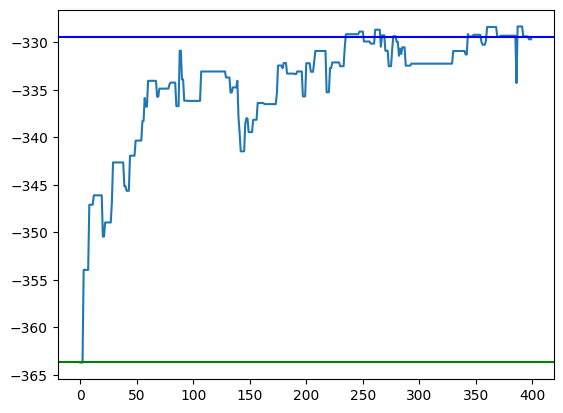

318.6116666793823


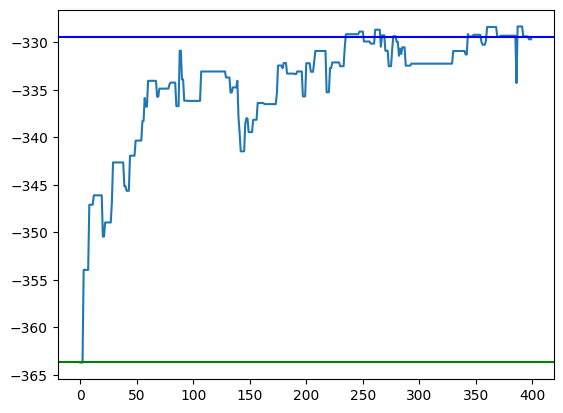

In [12]:

# all_data = np.array(phys_compiled)
# all_data = train_data

fidx = 4
codetrain_data = codetrain_datas[fidx]
codetest_data = codetest_datas[fidx]

Kval = 6
iterations = 1000
warmups = 250

hmctimerec = []
hmcthetarec = []
hmcexpthetarec = []

samples = []
lls = []
step = 4
# theta = np.random.rand(7)
# theta = theta / sum(theta)
# theta = expectation.copy()
z = np.array([1.0/7] * 7)
# z = expectation.copy() * 1000
original_theta = copy.deepcopy(z/sum(z))

exp_theta = copy.deepcopy(original_theta)
# alpha = 10
epsilon = 0.24
L = 10
sigma = 1
mean = np.zeros(7)
cov =  np.eye(7) * sigma
v = np.random.multivariate_normal(mean, cov)
# constant_alpha = np.array([0.5] * 7)

# changed = False
new_times = 0
ll_of_ori = np.sum(np.log(approximate_prob(codetrain_data, original_theta, True, K=Kval)))

gradientV = grad((lambda z,data, K:V_withoutnorm(z, data, K)))
start_time = time.time()
for iter in range(1, iterations + 1):
  new_z = copy.deepcopy(z)
  curr_theta = softmax(z)
  # print(new_z)
  # if(changed):
  #   print(curr_theta)
  if(iter > warmups):
    exp_theta = (exp_theta * (iter - warmups) + curr_theta) / (iter-warmups + 1)
    hmctimerec.append(time.time() - start_time)
    hmcexpthetarec.append(exp_theta)
  curr_ll = np.sum(np.log(approximate_prob(codetrain_data, curr_theta, True, K=Kval)))
  lls.append(curr_ll)
  

  v = np.random.multivariate_normal(mean, cov)
  # print(gradV(new_z, train_data, K= Kval))
  old_v = copy.deepcopy(v)
  est = gradientV(new_z, codetrain_data, K= Kval)
  # epsilon = 1/(est @ est)
  # print( est)
  # print(new_z)


  # Leap-frog!
  v = v - epsilon/2 * gradientV(new_z, codetrain_data, K= Kval)
  for j in range(0,L):
    new_z = new_z + epsilon * v
    if(j < L - 1):
       v = v - epsilon* gradientV(new_z, codetrain_data, K= Kval)
  v = v - epsilon/2 * gradientV(new_z, codetrain_data, K= Kval)
  

  T_new = v @ v * 0.5 * sigma
  T_old = old_v @ old_v * 0.5 * sigma
  V_new = V_withoutnorm(new_z, codetrain_data, K=Kval)
  V_old = V_withoutnorm(z, codetrain_data, K=Kval)
  
  acceptance = np.exp(T_old+V_old - T_new-V_new)
  # print(acceptance)
  if(acceptance > 1):
    # print(iter, acceptance)
    z = new_z
    changed  = True
  else:
    coin = np.random.rand(1)[0]
    if(coin < acceptance):
      # print(iter, coin, acceptance)
      z = new_z
      changed = True
    else:
      changed = False
  if changed:
    new_times += 1

  # hmcthetarec.append(softmax(z))
  if(iter% step == 0):
    
    display.clear_output(wait=True)
    print(f"rate: {new_times / iter}")
    print(original_theta)
    print(exp_theta)
    
    ll_of_exp = np.sum(np.log(approximate_prob(codetrain_data, exp_theta, True, K = Kval)))
    plt.clf()
    plt.plot(lls)
    plt.axhline(y = ll_of_ori, color = 'g', linestyle = '-')
    plt.axhline(y = ll_of_exp, color = 'b', linestyle = '-')
    display.display(plt.gcf())
    
    sleep(0.001)
  #   print(f"Iter {iter}")
  #   print(acceptance)
hmcelapse = time.time() - start_time
hmctheta = exp_theta
print(hmcelapse)
# hmc_times[fidx] = hmcelapse

In [ ]:
hmc_equaltrained_thetas[fidx] = hmctheta
print(hmc_equaltrained_thetas)

[array([0.29554452, 0.18112238, 0.07732853, 0.00853996, 0.18284048,
       0.12263219, 0.13199193]), array([0.30155031, 0.17546901, 0.07476987, 0.02087587, 0.22296939,
       0.10967702, 0.09468853]), array([0.28620784, 0.17517175, 0.05619517, 0.02585657, 0.22234705,
       0.12510541, 0.10911622]), array([0.32901831, 0.17099593, 0.0708682 , 0.01407576, 0.20243264,
       0.09462212, 0.11798703]), array([0.29186099, 0.18611001, 0.06445291, 0.01381442, 0.20408447,
       0.10630204, 0.13337516])]


In [ ]:
np.save("hmc_equaltrained_thetas.npy", np.array(hmc_equaltrained_thetas))

In [ ]:
print(hmc_times)
print(np.mean(hmc_times))

[637.6336772441864, 622.1516804695129, 580.8612506389618, 581.4101543426514, 648.211793422699]
614.0537112236022


In [ ]:
hmc_trained_thetas[fidx] = hmctheta
print(hmc_trained_thetas)

[array([0.27813077, 0.17187573, 0.07310783, 0.0085706 , 0.18986636,
       0.1370409 , 0.14140781]), array([0.31675443, 0.1720822 , 0.07535505, 0.00884578, 0.22172513,
       0.11128049, 0.09395693]), array([0.32963949, 0.17096004, 0.05051328, 0.0203734 , 0.21951428,
       0.11280022, 0.09619928]), array([0.35126046, 0.17104781, 0.06222926, 0.02094911, 0.18562224,
       0.10029548, 0.10859564]), array([0.28755561, 0.1714738 , 0.06827127, 0.00798296, 0.20413961,
       0.12296038, 0.13761638])]


In [ ]:
np.save("hmc_trained_thetas.npy", np.array(hmc_trained_thetas))

In [ ]:
np.save("hmctimerec.npy", np.array(hmctimere+c))
np.save("hmcexpthetarec.npy", np.array(hmcexpthetarec))

## Posterior through VI with Gaussian q(theta)

In [14]:
def log_joint(theta, data, eta = np.ones(7), K = -1):
  logprob = 0.0
  for prog in data:
    # prog = compile(code)
    for opcode in prog.getnodes():
      logprob += np.log(theta[PhyExpr.phymap[opcode]])
    # print(theta)
    logprob -= np.log(depth_normalizer(theta, K))
    # res.append(logprob)
  logprob += logdirichlet(theta, eta)
  return logprob

def logq(z, mu, sigma):
  M = len(z)
  res = 0
  res -= M/2*np.log(2*np.pi)
  res -= 1/2*np.sum(np.log(sigma * sigma))
  diff = z - mu
  res -= 0.5 * np.sum(diff * np.reciprocal(sigma * sigma) * diff)
  return res


def elbo(epsilon, data, mu, sigma, K=8, eta = np.ones(7)):
  z = mu + sigma * epsilon
  theta = sm(z)
  # print(logdirichlet(theta, eta))
  return log_joint(theta, data, eta, K) - logq(z, mu, sigma)

# def getgrad(epsilon, data, mu, sigma, K):
#   # epsilon = np.random.rand(1)[0]
#   z = mu + sigma * epsilon
#   theta = sm(z)
#   return elbo(theta, data, mu, sigma, K)

In [ ]:
svidurations = [None] * num_fold

Iter 200: [0.30275983 0.18088447 0.05941809 0.02375644 0.20479021 0.10359408
 0.12479688], [0.17486335 0.19426069 0.35264408 0.47351483 0.21424003 0.26922187
 0.23808995]
curr=-326.32396842910396, avg=-336.7632898524498


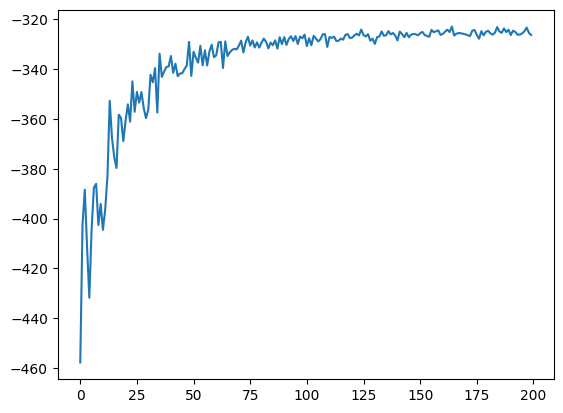

506.6040749549866


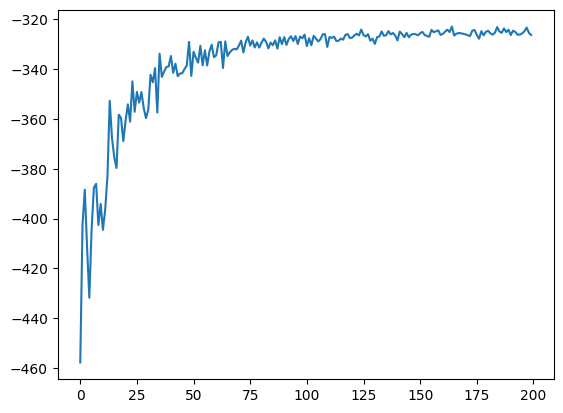

In [15]:
fidx = 4
codetrain_data = codetrain_datas[fidx]
codetest_data = codetest_datas[fidx]

lr = 1e-3
Kval = 6
mu = np.ones(7)/7.0
sigma = np.ones(7)

gradfun = lambda mu, sigma, epsilon, train_data: elbo(epsilon, train_data, mu,sigma, Kval, np.ones(7))
gradmu = grad(gradfun, 0)
gradsigma = grad(gradfun, 1)
esamples = 5
iteration = 200
period = 1
start_time = time.time()
avg_elbos = []
elbo_list = []

svitimerec = []
sviexpthetarec =[]

for iter in range(1, iteration + 1):
  # if(iter % period == 0):
  gmu = np.zeros(7)
  gsigma = np.zeros(7)
  curr_elbos = 0.0
  for es in range(esamples):
    epsilon = np.random.normal(size=7)
    
    gmu += gradmu(mu, sigma, epsilon, codetrain_data)/esamples
    gsigma += gradsigma(mu, sigma, epsilon, codetrain_data)/esamples
    curr_elbos += elbo(epsilon, codetrain_data, mu, sigma, K=Kval)/esamples
  
  elbo_list.append(curr_elbos)
  avg_elbos.append(sum(elbo_list)/len(elbo_list))
  mu += lr * gmu
  sigma += lr * gsigma
  svitimerec.append(time.time() - start_time)
  sviexpthetarec.append(softmax(mu))
  if(iter % period == 0):
    display.clear_output(wait=True)
    print(f"Iter {iter}: {sm(mu)}, {sigma}")
    print(f"curr={curr_elbos}, avg={avg_elbos[-1]}")
    plt.clf()
    plt.plot(elbo_list)
    # plt.plot(avg_elbos)
    display.display(plt.gcf())
    sleep(0.001)
exp_theta = sm(mu)
svielapse = time.time() - start_time
print(svielapse)
svitheta = exp_theta
# svitimes[fidx] = svielapse

In [ ]:
svi_equaltrained_thetas[fidx] = svitheta
print(svi_equaltrained_thetas)

[array([0.30449349, 0.19209902, 0.06381693, 0.01696544, 0.18435562,
       0.12753842, 0.11073109]), array([0.31756016, 0.1767369 , 0.0664667 , 0.01426336, 0.22558685,
       0.10627416, 0.09311187]), array([0.31451155, 0.17826723, 0.04635014, 0.01811327, 0.23205854,
       0.11279542, 0.09790386]), array([0.33204568, 0.16603654, 0.05795619, 0.01835186, 0.20697293,
       0.09866549, 0.11997132]), array([0.3119534 , 0.1836673 , 0.05761002, 0.01658763, 0.2038263 ,
       0.10311689, 0.12323846])]


In [ ]:
np.save("svi_equaltrained_thetas.npy", np.array(svi_equaltrained_thetas))

In [ ]:
svi_trained_thetas[fidx] = svitheta
print(svi_trained_thetas)

In [ ]:
print(svidurations)
np.save("svidurations.npy", np.array(svidurations))

[286.33951473236084, 280.85560941696167, 280.26811146736145, 279.32001876831055, 303.25697660446167]


In [ ]:
svi_trained_thetas[fidx] = svitheta
print(svi_trained_thetas)

[array([0.28765404, 0.1735914 , 0.07587359, 0.04098506, 0.1821272 ,
       0.12687239, 0.11289632]), array([0.29534534, 0.16090279, 0.07728501, 0.03865592, 0.22047804,
       0.11032197, 0.09701093]), array([0.29364919, 0.16003719, 0.06340066, 0.0431529 , 0.22323768,
       0.11406581, 0.10245657]), array([0.31082514, 0.14687842, 0.07256891, 0.0434311 , 0.20483115,
       0.10321815, 0.11824713]), array([0.28885614, 0.17126484, 0.06942698, 0.04022485, 0.20161254,
       0.10589164, 0.12272302])]


In [ ]:
np.save("svi_trained_thetas.npy", np.array(svi_trained_thetas))

In [ ]:
np.save("svitimerec.npy", np.array(svitimerec))
np.save("sviexpthetarec.npy", np.array(sviexpthetarec))

In [ ]:
mhexpthetarec[0]

array([0.30808461, 0.20213777, 0.08388251, 0.01751081, 0.20762348,
       0.08718464, 0.09357618])

In [100]:
base_theta = np.ones(7)/7.0
base_probs = approximate_prob(phys_compiled,base_theta,True, K=Kval)
test_mh_probs = [None] * num_fold
train_mh_probs = [None] * num_fold
test_hmc_probs = [None] * num_fold
train_hmc_probs = [None] * num_fold
test_svi_probs = [None] * num_fold
train_svi_probs = [None] * num_fold
Kval = 6
baseline_times = []
mh_times = []
hmc_times = []
svi_times = []

base_lls = []
mh_lls = []
hmc_lls = []
svi_lls = []

mh_set = []
hmc_set = []
svi_set = []

mh_meanset = []
hmc_meanset = []
svi_meanset = []

for fidx in range(num_fold):
  codetrain_data = codetrain_datas[fidx]
  codetest_data = codetest_datas[fidx]
  print(f"{fidx}:{[pg.tostr() for pg in codetest_data]}")
  baseline_probs = approximate_prob(codetest_data, base_theta, True, K= Kval)
  base_lls.append([np.log(prob) for prob in baseline_probs])
  basetime = [int(1/prob) for prob in baseline_probs]
  baseline_times += basetime

  test_mh_probs[fidx] = approximate_prob(codetest_data, mh_trained_thetas[fidx], True, K= Kval)
  mh_lls.append([np.log(prob) for prob in test_mh_probs[fidx]])
  mhtime = [int(1/prob) for prob in test_mh_probs[fidx]]
  mh_times += mhtime

  mh_set += [sum(basetime)/sum(mhtime)]
  mh_meanset += [mean([basetime[i]/mhtime[i] for i in range(len(basetime))])]

  train_mh_probs[fidx] = approximate_prob(codetrain_data, mh_trained_thetas[fidx], True, K= Kval)
  test_hmc_probs[fidx] = approximate_prob(codetest_data, hmc_trained_thetas[fidx], True, K= Kval)

  hmc_lls.append([np.log(prob) for prob in test_hmc_probs[fidx]])
  hmctime = [int(1/prob) for prob in test_hmc_probs[fidx]]
  hmc_times += hmctime

  hmc_set += [sum(basetime)/sum(hmctime)]
  hmc_meanset += [mean([basetime[i]/hmctime[i] for i in range(len(basetime))])]

  train_hmc_probs[fidx] = approximate_prob(codetrain_data, hmc_trained_thetas[fidx], True, K= Kval)
  test_svi_probs[fidx] = approximate_prob(codetest_data, svi_trained_thetas[fidx], True, K= Kval)
  svi_lls.append([np.log(prob) for prob in test_svi_probs[fidx]])
  svitime = [int(1/prob) for prob in test_svi_probs[fidx]]
  svi_times += svitime
  svi_set += [sum(basetime)/sum(svitime)]
  svi_meanset += [mean([basetime[i]/svitime[i] for i in range(len(basetime))])]

  train_svi_probs[fidx] = approximate_prob(codetrain_data, svi_trained_thetas[fidx], True, K= Kval)

mh_speedups = []
hmc_speedups = []
svi_speedups = []
for i in range(len(baseline_times)):
  mh_speedups.append(baseline_times[i] / mh_times[i])
  hmc_speedups.append(baseline_times[i] / hmc_times[i])
  svi_speedups.append(baseline_times[i] / svi_times[i])


mh_times_s = sorted(mh_times)
hmc_times_s = sorted(hmc_times)
svi_times_s = sorted(svi_times)
baseline_times_s = sorted(baseline_times)
def mean(x):
  return sum(x) / len(x)

0:['(/ V0 V1)', '(* V0 V1)', '(* C3.14 (^ V0 C2))', '(+ V0 V1)', '(* V0 V1)', '(* V0 (* V1 V2))', '(* V0 (* V1 C9.8))', '(* C0.5 (* V0 (^ V1 C2)))', '(* C0.5 (* V0 (^ V1 C2)))']
1:['(* C0.5 (* V0 (^ V1 C2)))', '(^ (+ (^ V0 C2) (* C2 (* V1 (- V2 V3)))) C0.5)', '(/ V0 V1)', '(/ V0 V1)', '(* (^ V0 C2) V1)', '(/ V0 V1)', '(/ (^ V0 C2) V1)', '(/ V0 (^ C2 C0.5))', '(* V0 (^ C3 C2))']
2:['(+ V0 V1)', '(* V0 V1)', '(+ V0 (* V1 V2))', '(/ (* C8.99 (* V0 V1)) (^ V2 C2))', '(^ (+ V0 (^ V1 C2)) C0.5)', '(* V0 V1)', '(/ (* C6.67 (* V0 V1)) (^ V2 C2))', '(^ (+ (^ V0 C2) (^ V1 C2)) C0.5)', '(/ C1 (+ (/ C1 V0) (/ C1 V1)))']
3:['(* (* C2 C3.14) (^ (/ V0 C9.8) C0.5))', '(* V0 V1)', '(* V0 V1)', '(+ V0 (+ (* V1 V2) (* C0.5 (* V3 (^ V2 C2)))))', '(* C0.5 (* V0 (^ V1 C2)))', '(* C0.5 (/ (^ V0 C2) V1))', '(/ C1 (+ (/ C1 V0) (/ C1 V1)))', '(/ C1 V0)', '(/ V0 C2)']
4:['(* V0 V1)', '(/ (* C2 C3.14) V0)', '(/ C1 V0)', '(* (* C2 C3.14) (^ (/ V0 V1) C0.5))', '(/ (+ (* V0 V2) (* V1 V3)) (+ V0 V1))', '(* V0 V1)']


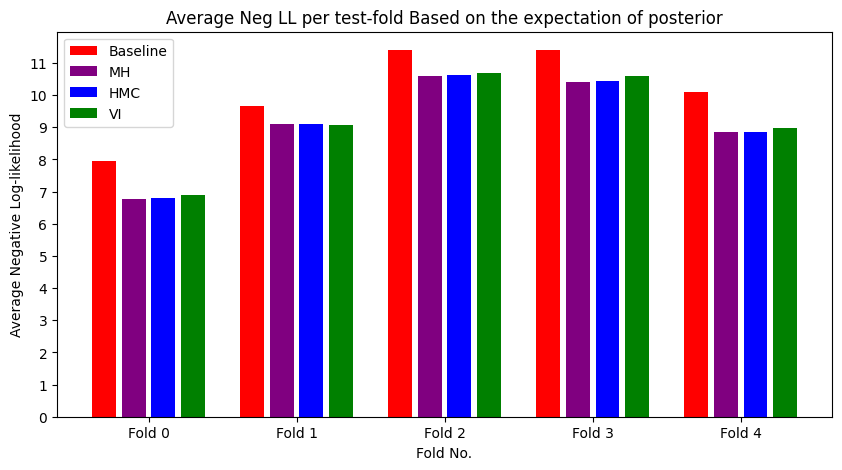

In [ ]:
space = 5
# plt.figure(dpi=1200)
plt.figure(figsize=(10,5))
plt.title("Average Neg LL per test-fold Based on the expectation of posterior")
plt.xlabel("Fold No.")
plt.ylabel("Average Negative Log-likelihood")
plt.yticks(np.arange(0, 12, 1.0))
plt.xticks([i * space + 1.5 for i in range(num_fold)], [f"Fold {i}" for i in range(num_fold)])
for i in range(num_fold):
  plt.bar(i*space+0, -mean(base_lls[i]), color="r", label = "Baseline" if i == 0 else None)
  plt.bar(i*space+1, -mean(mh_lls[i]),color="purple", label = "MH" if i == 0 else None)
  plt.bar(i*space+2, -mean(hmc_lls[i]), color="blue", label = "HMC" if i == 0 else None)
  plt.bar(i*space+3, -mean(svi_lls[i]),color="green", label = "VI" if i == 0 else None)
plt.legend(loc="upper left")
plt.savefig('NLL.png', dpi=300)

In [ ]:
print(base_lls)
print(mh_lls)
print(hmc_lls)
print(svi_lls)

[[-4.914067499837266, -4.914067499837266, -8.805887797947893, -4.914067499837266, -4.914067499837266, -8.805887797947893, -8.805887797947893, -12.69770809605852, -12.69770809605852], [-12.69770809605852, -24.3731689903904, -4.914067499837266, -4.914067499837266, -8.805887797947893, -4.914067499837266, -8.805887797947893, -8.805887797947893, -8.805887797947893], [-4.914067499837266, -4.914067499837266, -8.805887797947893, -16.589528394169147, -12.69770809605852, -4.914067499837266, -16.589528394169147, -16.589528394169147, -16.589528394169147], [-16.589528394169147, -4.914067499837266, -4.914067499837266, -24.3731689903904, -12.69770809605852, -12.69770809605852, -16.589528394169147, -4.914067499837266, -4.914067499837266], [-4.914067499837266, -8.805887797947893, -4.914067499837266, -16.589528394169147, -20.481348692279774, -4.914067499837266]]
[[-4.2514682036310365, -3.848920354581144, -8.087361696635087, -4.955540783426275, -3.848920354581144, -6.69964834136649, -7.124446000520113, -

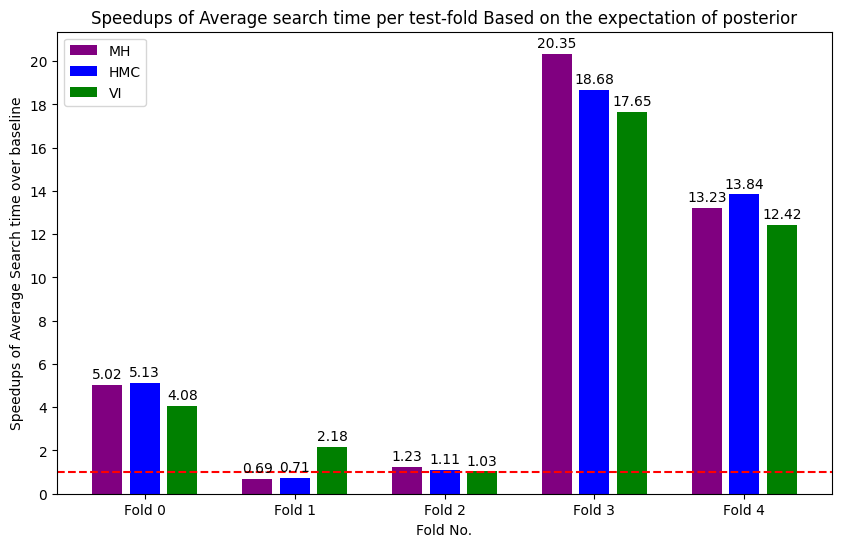

In [101]:
space = 4
margin = 0.3
plt.figure(figsize=(10,6))
plt.title("Speedups of Average search time per test-fold Based on the expectation of posterior")
plt.xlabel("Fold No.")
plt.ylabel("Speedups of Average Search time over baseline")
plt.yticks(np.arange(0, 21, 2.0))
plt.xticks([i * space + 1 for i in range(num_fold)], [f"Fold {i}" for i in range(num_fold)])
for i in range(num_fold):
  plt.bar(i*space+0, mh_set[i],color="purple", label = "MH" if i == 0 else None)
  plt.text(i*space+0,mh_set[i] + margin,f"{mh_set[i]:.2f}", ha="center")
  plt.bar(i*space+1, hmc_set[i], color="blue", label = "HMC" if i == 0 else None)
  plt.text(i*space+1,hmc_set[i] + margin,f"{hmc_set[i]:.2f}", ha="center")
  plt.bar(i*space+2, svi_set[i],color="green", label = "VI" if i == 0 else None)
  plt.text(i*space+2,svi_set[i] + margin,f"{svi_set[i]:.2f}", ha="center")

plt.axhline(y = 1, color = 'r', linestyle = '--')
plt.legend(loc="upper left")
plt.savefig('foldspeedups.png', dpi=300)

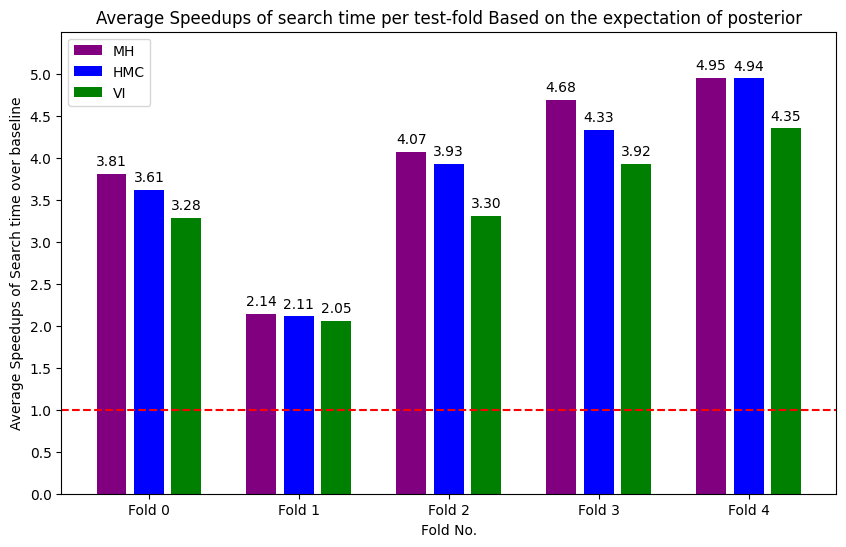

In [ ]:
space = 4
margin = 0.1
plt.figure(figsize=(10,6))
plt.title("Average Speedups of search time per test-fold Based on the expectation of posterior")
plt.xlabel("Fold No.")
plt.ylabel("Average Speedups of Search time over baseline")
plt.ylim([0,5.5])
plt.yticks(np.arange(0, 5.1, 0.5))
plt.xticks([i * space + 1 for i in range(num_fold)], [f"Fold {i}" for i in range(num_fold)])
for i in range(num_fold):
  plt.bar(i*space+0, mh_meanset[i],color="purple", label = "MH" if i == 0 else None)
  plt.text(i*space+0,mh_meanset[i] + margin,f"{mh_meanset[i]:.2f}", ha="center")
  plt.bar(i*space+1, hmc_meanset[i], color="blue", label = "HMC" if i == 0 else None)
  plt.text(i*space+1,hmc_meanset[i] + margin,f"{hmc_meanset[i]:.2f}", ha="center")
  plt.bar(i*space+2, svi_meanset[i],color="green", label = "VI" if i == 0 else None)
  plt.text(i*space+2,svi_meanset[i] + margin,f"{svi_meanset[i]:.2f}", ha="center")

plt.axhline(y = 1, color = 'r', linestyle = '--')
plt.legend(loc="upper left")
plt.savefig('foldmeanspeedups.png', dpi=300)

In [ ]:
baseline_times_o = baseline_times[:10] + baseline_times[11:]
mh_times_o = mh_times[:10] + mh_times[11:]
hmc_times_o = hmc_times[:10] + hmc_times[11:]
svi_times_o = svi_times[:10] + svi_times[11:]

In [ ]:
cutoff = 0
mh_sk = sum(mh_times_s[cutoff:-cutoff if cutoff > 0 else len(mh_times_s)])
hmc_sk = sum(hmc_times_s[cutoff:-cutoff if cutoff > 0 else len(hmc_times_s)])
svi_sk = sum(svi_times_s[cutoff:-cutoff if cutoff > 0 else len(svi_times_s)])
baseline_sk = sum(baseline_times_s[cutoff:-cutoff if cutoff > 0 else len(baseline_times_s)])
print(baseline_sk/mh_sk, baseline_sk/hmc_sk,baseline_sk/svi_sk)

1.3431285038235037 1.385336849731968 3.9880671483016514


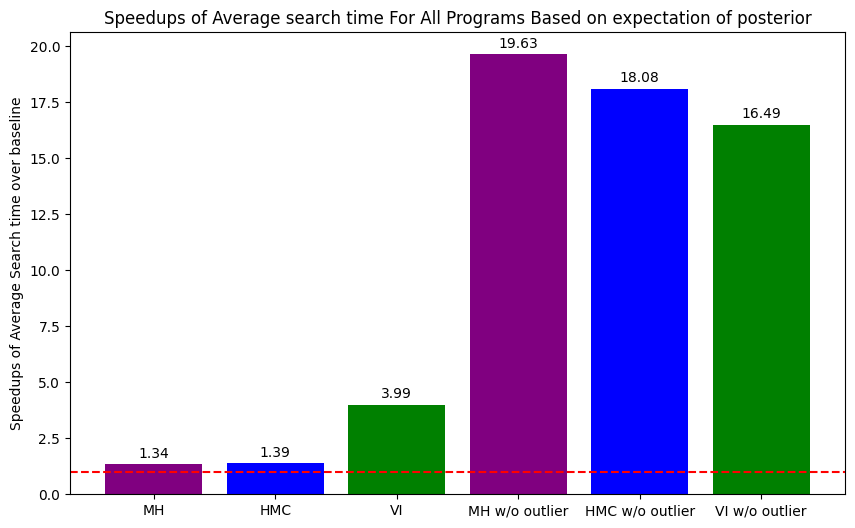

In [ ]:
space = 0
margin = 0.3
plt.figure(figsize=(10,6))
plt.title("Speedups of Average search time For All Programs Based on expectation of posterior")
# plt.xlabel("Fold No.")
plt.ylabel("Speedups of Average Search time over baseline")
# plt.xticks(np.arange(0, 11, 1.0))
# plt.yticks(np.arange(0, 21, 2.0))
plt.xticks([space + i for i in range(6)], ["MH", "HMC", "VI", "MH w/o outlier", "HMC w/o outlier","VI w/o outlier"])
# for i in range(num_fold):
plt.bar(space+0, baseline_sk/mh_sk,color="purple", label = "MH")
plt.text(space+0,baseline_sk/mh_sk + margin,f"{baseline_sk/mh_sk:.2f}", ha="center")
plt.bar(space+1, baseline_sk/hmc_sk, color="blue", label = "HMC")
plt.text(space+1,baseline_sk/hmc_sk + margin,f"{baseline_sk/hmc_sk:.2f}", ha="center")
# plt.text(1,hmc_set[i] + margin,f"{hmc_set[i]:.2f}", ha="center")
plt.bar(space+2, baseline_sk/svi_sk,color="green", label = "VI")
plt.text(space+2,baseline_sk/svi_sk + margin,f"{baseline_sk/svi_sk:.2f}", ha="center")
plt.bar(space+3, sum(baseline_times_o)/sum(mh_times_o),color="purple", label = "MH w/o outlier")
plt.text(space+3,sum(baseline_times_o)/sum(mh_times_o) + margin,f"{sum(baseline_times_o)/sum(mh_times_o):.2f}", ha="center")
plt.bar(space+4, sum(baseline_times_o)/sum(hmc_times_o),color="blue", label = "HMC w/o outlier")
plt.text(space+4,sum(baseline_times_o)/sum(hmc_times_o) + margin,f"{sum(baseline_times_o)/sum(hmc_times_o):.2f}", ha="center")
plt.bar(space+5, sum(baseline_times_o)/sum(svi_times_o),color="green", label = "SVI w/o outlier")
plt.text(space+5,sum(baseline_times_o)/sum(svi_times_o) + margin,f"{sum(baseline_times_o)/sum(svi_times_o):.2f}", ha="center")
# plt.text(2,svi_set[i] + margin,f"{svi_set[i]:.2f}", ha="center")

plt.axhline(y = 1, color = 'r', linestyle = '--')
# plt.legend(loc="upper left")

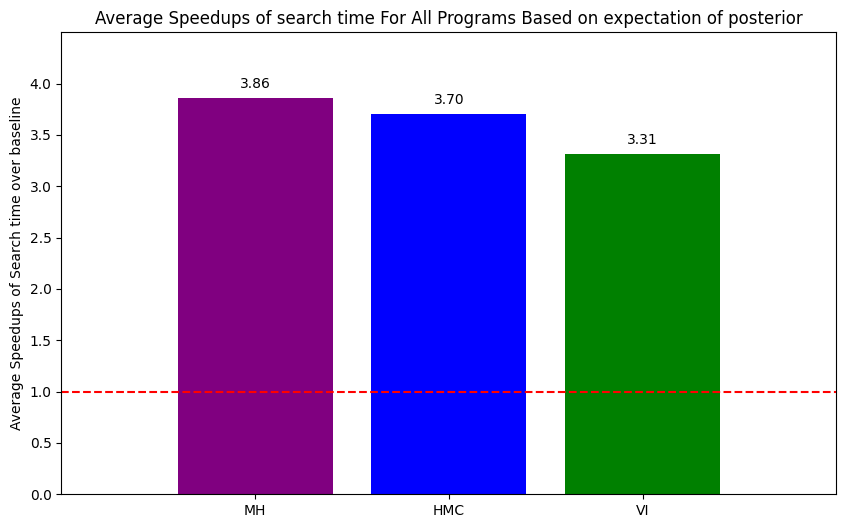

In [ ]:
space = 1
margin = 0.1
plt.figure(figsize=(10,6))
plt.title("Average Speedups of search time For All Programs Based on expectation of posterior")
# plt.xlabel("Fold No.")
plt.ylabel("Average Speedups of Search time over baseline")
# plt.xticks(np.arange(0, 11, 1.0))
plt.yticks(np.arange(0, 4.1, 0.5))
plt.xlim([0.0,4.0])
plt.ylim([0.0,4.5])
plt.xticks([space + i for i in range(3)], ["MH", "HMC", "VI"])
# for i in range(num_fold):
plt.bar(space+0, mean(mh_speedups),color="purple", label = "MH")
plt.text(space+0,mean(mh_speedups) + margin,f"{mean(mh_speedups):.2f}", ha="center")
plt.bar(space+1, mean(hmc_speedups), color="blue", label = "HMC")
plt.text(space+1,mean(hmc_speedups) + margin,f"{mean(hmc_speedups):.2f}", ha="center")
plt.bar(space+2, mean(svi_speedups), color="green", label = "VI")
plt.text(space+2,mean(svi_speedups) + margin,f"{mean(svi_speedups):.2f}", ha="center")

plt.axhline(y = 1, color = 'r', linestyle = '--')
# plt.legend(loc="upper left")

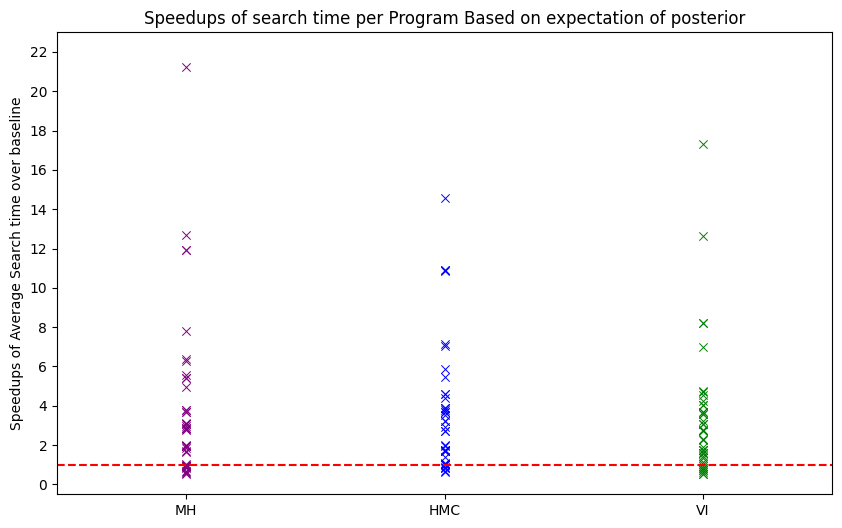

In [ ]:
space = 0
margin = 0.3
plt.figure(figsize=(10,6))
plt.title("Speedups of search time per Program Based on expectation of posterior")
# plt.xlabel("Fold No.")
plt.ylabel("Speedups of Average Search time over baseline")
plt.xticks(np.arange(0, 5, 1.0))
plt.yticks(np.arange(0, 23, 2.0))
plt.xlim([0.5,3.5])
plt.ylim([-0.5,23])
plt.xticks([1,2,3], ["MH", "HMC", "VI"])
# for i in range(num_fold):
for sp in mh_speedups:
  plt.scatter(space+1, sp, marker="x",linewidths=0.7, color="purple")
for sp in hmc_speedups:
  plt.scatter(space+2, sp, marker="x",linewidths=0.7, color="b")
for sp in svi_speedups:
  plt.scatter(space+3, sp, marker="x",linewidths=0.7, color="g")

plt.axhline(y = 1, color = 'r', linestyle = '--')
# plt.legend(loc="upper left")

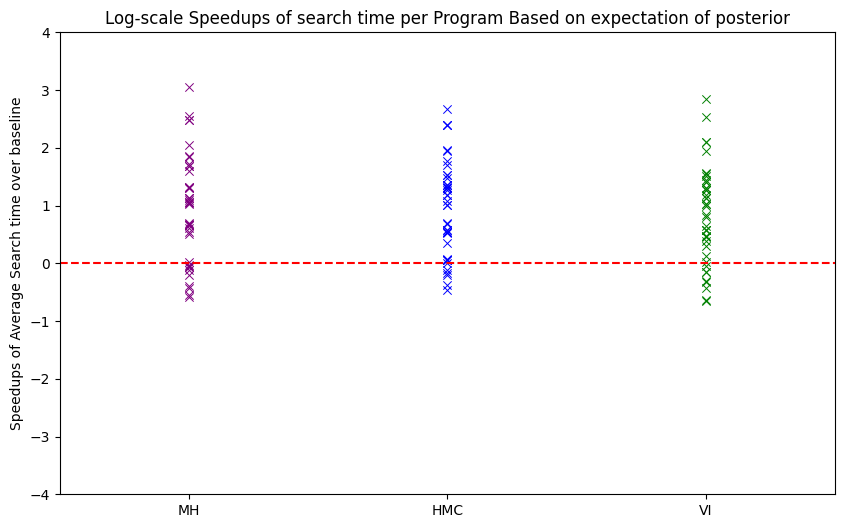

In [ ]:
space = 0
margin = 0.3
plt.figure(figsize=(10,6))
plt.title("Log-scale Speedups of search time per Program Based on expectation of posterior")
# plt.xlabel("Fold No.")
plt.ylabel("Speedups of Average Search time over baseline")
plt.xticks(np.arange(0, 5, 1.0))
plt.yticks(np.arange(-4, 4.1, 1.0))
plt.xlim([0.5,3.5])
plt.ylim([-4,4])
plt.xticks([1,2,3], ["MH", "HMC", "VI"])
# for i in range(num_fold):
for sp in mh_speedups:
  plt.scatter(space+1, np.log(sp), marker="x",linewidths=0.7, color="purple")
for sp in hmc_speedups:
  plt.scatter(space+2, np.log(sp), marker="x",linewidths=0.7, color="b")
for sp in svi_speedups:
  plt.scatter(space+3, np.log(sp), marker="x",linewidths=0.7, color="g")

plt.axhline(y = 0, color = 'r', linestyle = '--')
# plt.legend(loc="upper left")

In [16]:
base_theta = np.ones(7)/7.0
base_probs = approximate_prob(phys_compiled,base_theta,True, K=Kval)
test_mh_probs = [None] * num_fold
train_mh_probs = [None] * num_fold
test_hmc_probs = [None] * num_fold
train_hmc_probs = [None] * num_fold
test_svi_probs = [None] * num_fold
train_svi_probs = [None] * num_fold
Kval = 6
baseline_times = []
mh_times = []
hmc_times = []
svi_times = []

base_lls = []
mh_lls = []
hmc_lls = []
svi_lls = []

mh_set = []
hmc_set = []
svi_set = []

mh_meanset = []
hmc_meanset = []
svi_meanset = []

for fidx in range(num_fold):
  codetrain_data = codetrain_datas[fidx]
  codetest_data = codetest_datas[fidx]
  print(f"{fidx}:{[pg.tostr() for pg in codetest_data]}")
  baseline_probs = approximate_prob(codetest_data, base_theta, True, K= Kval)
  base_lls.append([np.log(prob) for prob in baseline_probs])
  basetime = [int(1/prob) for prob in baseline_probs]
  baseline_times += basetime

  test_mh_probs[fidx] = approximate_prob(codetest_data, mh_equaltrained_thetas[fidx], True, K= Kval)
  mh_lls.append([np.log(prob) for prob in test_mh_probs[fidx]])
  mhtime = [int(1/prob) for prob in test_mh_probs[fidx]]
  mh_times += mhtime

  mh_set += [sum(basetime)/sum(mhtime)]
  mh_meanset += [mean([basetime[i]/mhtime[i] for i in range(len(basetime))])]

  train_mh_probs[fidx] = approximate_prob(codetrain_data, mh_equaltrained_thetas[fidx], True, K= Kval)
  test_hmc_probs[fidx] = approximate_prob(codetest_data, hmc_equaltrained_thetas[fidx], True, K= Kval)

  hmc_lls.append([np.log(prob) for prob in test_hmc_probs[fidx]])
  hmctime = [int(1/prob) for prob in test_hmc_probs[fidx]]
  hmc_times += hmctime

  hmc_set += [sum(basetime)/sum(hmctime)]
  hmc_meanset += [mean([basetime[i]/hmctime[i] for i in range(len(basetime))])]

  train_hmc_probs[fidx] = approximate_prob(codetrain_data, hmc_equaltrained_thetas[fidx], True, K= Kval)
  test_svi_probs[fidx] = approximate_prob(codetest_data, svi_equaltrained_thetas[fidx], True, K= Kval)
  svi_lls.append([np.log(prob) for prob in test_svi_probs[fidx]])
  svitime = [int(1/prob) for prob in test_svi_probs[fidx]]
  svi_times += svitime
  svi_set += [sum(basetime)/sum(svitime)]
  svi_meanset += [mean([basetime[i]/svitime[i] for i in range(len(basetime))])]

  train_svi_probs[fidx] = approximate_prob(codetrain_data, svi_equaltrained_thetas[fidx], True, K= Kval)

mh_speedups = []
hmc_speedups = []
svi_speedups = []
for i in range(len(baseline_times)):
  mh_speedups.append(baseline_times[i] / mh_times[i])
  hmc_speedups.append(baseline_times[i] / hmc_times[i])
  svi_speedups.append(baseline_times[i] / svi_times[i])


mh_times_s = sorted(mh_times)
hmc_times_s = sorted(hmc_times)
svi_times_s = sorted(svi_times)
baseline_times_s = sorted(baseline_times)


0:['(/ V0 V1)', '(* V0 V1)', '(* C3.14 (^ V0 C2))', '(+ V0 V1)', '(* V0 V1)', '(* V0 (* V1 V2))', '(* V0 (* V1 C9.8))', '(* C0.5 (* V0 (^ V1 C2)))', '(* C0.5 (* V0 (^ V1 C2)))']
1:['(* C0.5 (* V0 (^ V1 C2)))', '(^ (+ (^ V0 C2) (* C2 (* V1 (- V2 V3)))) C0.5)', '(/ V0 V1)', '(/ V0 V1)', '(* (^ V0 C2) V1)', '(/ V0 V1)', '(/ (^ V0 C2) V1)', '(/ V0 (^ C2 C0.5))', '(* V0 (^ C3 C2))']
2:['(+ V0 V1)', '(* V0 V1)', '(+ V0 (* V1 V2))', '(/ (* C8.99 (* V0 V1)) (^ V2 C2))', '(^ (+ V0 (^ V1 C2)) C0.5)', '(* V0 V1)', '(/ (* C6.67 (* V0 V1)) (^ V2 C2))', '(^ (+ (^ V0 C2) (^ V1 C2)) C0.5)', '(/ C1 (+ (/ C1 V0) (/ C1 V1)))']
3:['(* (* C2 C3.14) (^ (/ V0 C9.8) C0.5))', '(* V0 V1)', '(* V0 V1)', '(+ V0 (+ (* V1 V2) (* C0.5 (* V3 (^ V2 C2)))))', '(* C0.5 (* V0 (^ V1 C2)))', '(* C0.5 (/ (^ V0 C2) V1))', '(/ C1 (+ (/ C1 V0) (/ C1 V1)))', '(/ C1 V0)', '(/ V0 C2)']
4:['(* V0 V1)', '(/ (* C2 C3.14) V0)', '(/ C1 V0)', '(* (* C2 C3.14) (^ (/ V0 V1) C0.5))', '(/ (+ (* V0 V2) (* V1 V3)) (+ V0 V1))', '(* V0 V1)']


In [ ]:
savehmc = hmc_times

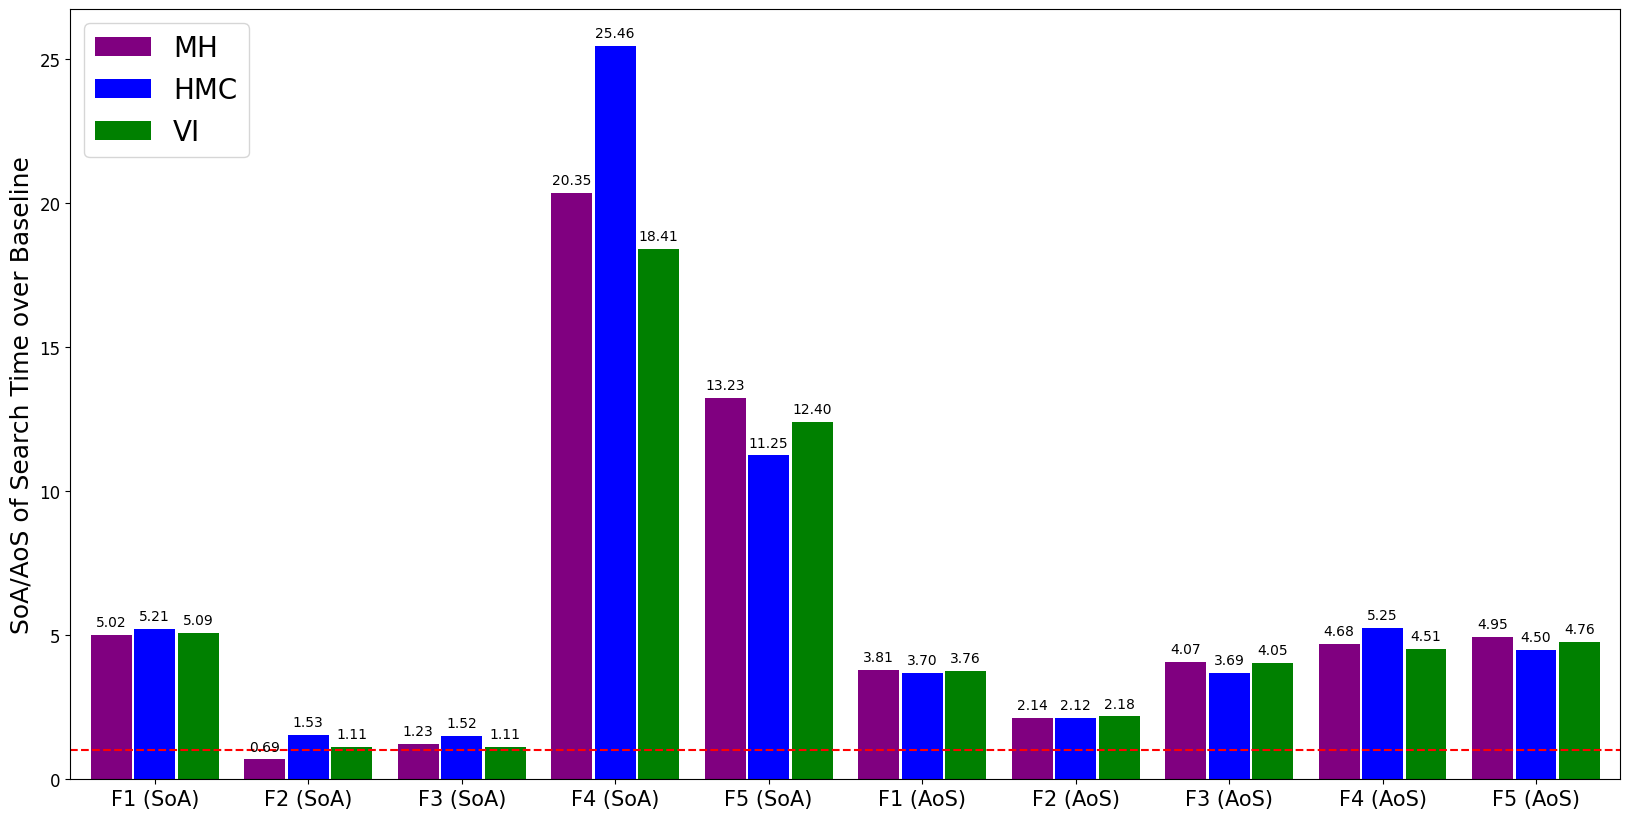

In [88]:
space = 3
margin = 0.3
plt.figure(figsize=(20,10))
# plt.title("SoA/AoS of Search time per Test-Fold Over the Baseline Based under the Inferred Posterior", fontsize = 18)
# plt.xlabel("Fold No.")
plt.ylabel("SoA/AoS of Search Time over Baseline", fontsize = 18)
plt.yticks(np.arange(0, 26, 5.0), fontsize = 12)
plt.xlim(-0.8,29.5)
plt.xticks([i * space + 1*0.85 for i in range(num_fold * 2)], [f"F{i+1} (SoA)" for i in range(num_fold)] + [f"F{i+1} (AoS)" for i in range(num_fold)], fontsize=15)
for i in range(num_fold):
  plt.bar(i*space+0, mh_set[i],color="purple", label = "MH" if i == 0 else None)
  plt.text(i*space+0,mh_set[i] + margin,f"{mh_set[i]:.2f}", ha="center")
  plt.bar(i*space+1*0.85, hmc_set[i], color="blue", label = "HMC" if i == 0 else None)
  plt.text(i*space+1*0.85,hmc_set[i] + margin,f"{hmc_set[i]:.2f}", ha="center")
  plt.bar(i*space+2*0.85, svi_set[i],color="green", label = "VI" if i == 0 else None)
  plt.text(i*space+2*0.85,svi_set[i] + margin,f"{svi_set[i]:.2f}", ha="center")
for i in range(num_fold):
  plt.bar((i+num_fold)*space+0, mh_meanset[i],color="purple")
  plt.text((i+num_fold)*space+0,mh_meanset[i] + margin,f"{mh_meanset[i]:.2f}", ha="center")
  plt.bar((i+num_fold)*space+1*0.85, hmc_meanset[i], color="blue")
  plt.text((i+num_fold)*space+1*0.85,hmc_meanset[i] + margin,f"{hmc_meanset[i]:.2f}", ha="center")
  plt.bar((i+num_fold)*space+2*0.85, svi_meanset[i],color="green")
  plt.text((i+num_fold)*space+2*0.85,svi_meanset[i] + margin,f"{svi_meanset[i]:.2f}", ha="center")

plt.axhline(y = 1, color = 'r', linestyle = '--')
plt.legend(loc="upper left", fontsize = 14, prop = { "size": 20 })
plt.savefig('soaaosfold_equal.png', dpi=300, bbox_inches='tight')

In [49]:
hmc_speedups[3]

1.182608695652174

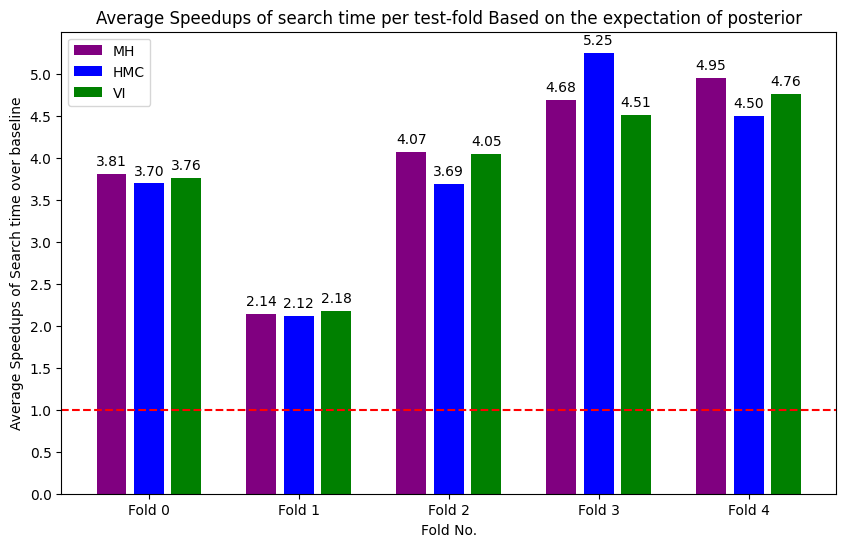

In [ ]:
space = 4
margin = 0.1
plt.figure(figsize=(10,6))
plt.title("Average Speedups of search time per test-fold Based on the expectation of posterior")
plt.xlabel("Fold No.")
plt.ylabel("Average Speedups of Search time over baseline")
plt.ylim([0,5.5])
plt.yticks(np.arange(0, 5.1, 0.5))
plt.xticks([i * space + 1 for i in range(num_fold)], [f"Fold {i}" for i in range(num_fold)])
for i in range(num_fold):
  plt.bar(i*space+0, mh_meanset[i],color="purple", label = "MH" if i == 0 else None)
  plt.text(i*space+0,mh_meanset[i] + margin,f"{mh_meanset[i]:.2f}", ha="center")
  plt.bar(i*space+1, hmc_meanset[i], color="blue", label = "HMC" if i == 0 else None)
  plt.text(i*space+1,hmc_meanset[i] + margin,f"{hmc_meanset[i]:.2f}", ha="center")
  plt.bar(i*space+2, svi_meanset[i],color="green", label = "VI" if i == 0 else None)
  plt.text(i*space+2,svi_meanset[i] + margin,f"{svi_meanset[i]:.2f}", ha="center")

plt.axhline(y = 1, color = 'r', linestyle = '--')
plt.legend(loc="upper left")
# plt.savefig('foldmeanspeedups.png', dpi=300)

In [93]:
baseline_times_o = baseline_times[:10] + baseline_times[11:]
mh_times_o = mh_times[:10] + mh_times[11:]
hmc_times_o = hmc_times[:10] + hmc_times[11:]
svi_times_o = svi_times[:10] + svi_times[11:]

mh_speedups_o = mh_speedups[:10] + mh_speedups[11:]
hmc_speedups_o = hmc_speedups[:10] + hmc_speedups[11:]
svi_speedups_o = svi_speedups[:10] + svi_speedups[11:]

In [91]:
cutoff = 0
mh_sk = sum(mh_times_s[cutoff:-cutoff if cutoff > 0 else len(mh_times_s)])
hmc_sk = sum(hmc_times_s[cutoff:-cutoff if cutoff > 0 else len(hmc_times_s)])
svi_sk = sum(svi_times_s[cutoff:-cutoff if cutoff > 0 else len(svi_times_s)])
baseline_sk = sum(baseline_times_s[cutoff:-cutoff if cutoff > 0 else len(baseline_times_s)])
print(baseline_sk/mh_sk, baseline_sk/hmc_sk,baseline_sk/svi_sk)

1.3431285038235037 2.9104844138508303 2.1185621483862414


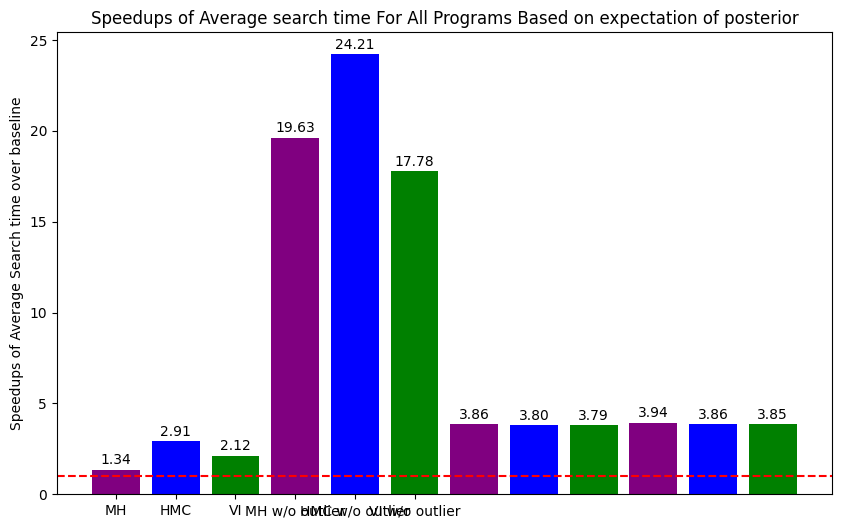

In [94]:
space = 0
margin = 0.3
plt.figure(figsize=(10,6))
plt.title("Speedups of Average search time For All Programs Based on expectation of posterior")
# plt.xlabel("Fold No.")
plt.ylabel("Speedups of Average Search time over baseline")
# plt.xticks(np.arange(0, 11, 1.0))
# plt.yticks(np.arange(0, 21, 2.0))
plt.xticks([space + i for i in range(6)], ["MH", "HMC", "VI", "MH w/o outlier", "HMC w/o outlier","VI w/o outlier"])
# for i in range(num_fold):
plt.bar(space+0, baseline_sk/mh_sk,color="purple", label = "MH")
plt.text(space+0,baseline_sk/mh_sk + margin,f"{baseline_sk/mh_sk:.2f}", ha="center")
plt.bar(space+1, baseline_sk/hmc_sk, color="blue", label = "HMC")
plt.text(space+1,baseline_sk/hmc_sk + margin,f"{baseline_sk/hmc_sk:.2f}", ha="center")
# plt.text(1,hmc_set[i] + margin,f"{hmc_set[i]:.2f}", ha="center")
plt.bar(space+2, baseline_sk/svi_sk,color="green", label = "VI")
plt.text(space+2,baseline_sk/svi_sk + margin,f"{baseline_sk/svi_sk:.2f}", ha="center")
plt.bar(space+3, sum(baseline_times_o)/sum(mh_times_o),color="purple", label = "MH w/o outlier")
plt.text(space+3,sum(baseline_times_o)/sum(mh_times_o) + margin,f"{sum(baseline_times_o)/sum(mh_times_o):.2f}", ha="center")
plt.bar(space+4, sum(baseline_times_o)/sum(hmc_times_o),color="blue", label = "HMC w/o outlier")
plt.text(space+4,sum(baseline_times_o)/sum(hmc_times_o) + margin,f"{sum(baseline_times_o)/sum(hmc_times_o):.2f}", ha="center")
plt.bar(space+5, sum(baseline_times_o)/sum(svi_times_o),color="green", label = "SVI w/o outlier")
plt.text(space+5,sum(baseline_times_o)/sum(svi_times_o) + margin,f"{sum(baseline_times_o)/sum(svi_times_o):.2f}", ha="center")

plt.bar(space+6, mean(mh_speedups),color="purple", label = "MH")
plt.text(space+6,mean(mh_speedups) + margin,f"{mean(mh_speedups):.2f}", ha="center")
plt.bar(space+7, mean(hmc_speedups), color="blue", label = "HMC")
plt.text(space+7,mean(hmc_speedups) + margin,f"{mean(hmc_speedups):.2f}", ha="center")
plt.bar(space+8, mean(svi_speedups), color="green", label = "VI")
plt.text(space+8,mean(svi_speedups) + margin,f"{mean(svi_speedups):.2f}", ha="center")

plt.bar(space+9, mean(mh_speedups_o),color="purple", label = "MH")
plt.text(space+9,mean(mh_speedups_o) + margin,f"{mean(mh_speedups_o):.2f}", ha="center")
plt.bar(space+10, mean(hmc_speedups_o), color="blue", label = "HMC")
plt.text(space+10,mean(hmc_speedups_o) + margin,f"{mean(hmc_speedups_o):.2f}", ha="center")
plt.bar(space+11, mean(svi_speedups_o), color="green", label = "VI")
plt.text(space+11,mean(svi_speedups_o) + margin,f"{mean(svi_speedups_o):.2f}", ha="center")

plt.axhline(y = 1, color = 'r', linestyle = '--')
# plt.legend(loc="upper left")

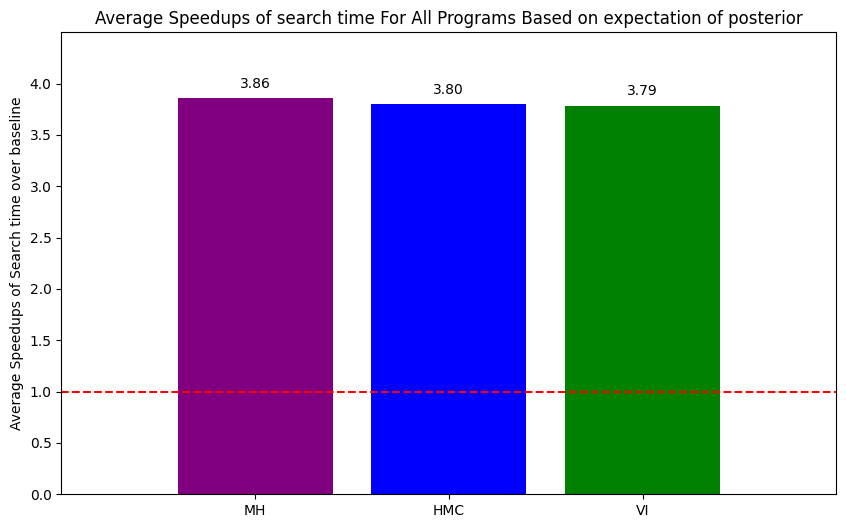

In [ ]:
space = 1
margin = 0.1
plt.figure(figsize=(10,6))
plt.title("Average Speedups of search time For All Programs Based on expectation of posterior")
# plt.xlabel("Fold No.")
plt.ylabel("Average Speedups of Search time over baseline")
# plt.xticks(np.arange(0, 11, 1.0))
plt.yticks(np.arange(0, 4.1, 0.5))
plt.xlim([0.0,4.0])
plt.ylim([0.0,4.5])
plt.xticks([space + i for i in range(3)], ["MH", "HMC", "VI"])
# for i in range(num_fold):
plt.bar(space+0, mean(mh_speedups),color="purple", label = "MH")
plt.text(space+0,mean(mh_speedups) + margin,f"{mean(mh_speedups):.2f}", ha="center")
plt.bar(space+1, mean(hmc_speedups), color="blue", label = "HMC")
plt.text(space+1,mean(hmc_speedups) + margin,f"{mean(hmc_speedups):.2f}", ha="center")
plt.bar(space+2, mean(svi_speedups), color="green", label = "VI")
plt.text(space+2,mean(svi_speedups) + margin,f"{mean(svi_speedups):.2f}", ha="center")

plt.axhline(y = 1, color = 'r', linestyle = '--')
# plt.legend(loc="upper left")

In [ ]:
# print(baseline_times)
print(mh_speedups)
print(hmc_speedups)
print(svi_speedups)

[1.9428571428571428, 2.9565217391304346, 2.0513372271749155, 0.9645390070921985, 2.9565217391304346, 8.217980295566502, 5.377115229653505, 5.810284475559267, 5.810284475559267, 4.960136518771331, 0.025803199425531734, 2.193548387096774, 2.193548387096774, 2.967096487327701, 2.193548387096774, 1.3902083333333333, 0.594900597307658, 1.2695966514459665, 0.7727272727272727, 4.0, 2.7827356130108423, 12.853173689585107, 0.6115191059396442, 4.0, 12.853173689585107, 0.5444488708353755, 0.8190978651513594, 2.554825511451197, 4.121212121212121, 4.121212121212121, 16.802292168152913, 6.509734830387004, 3.3355128270515633, 0.5863473129447543, 0.9714285714285714, 0.9714285714285714, 3.5789473684210527, 1.784701791922974, 0.9577464788732394, 6.853905467337732, 11.628627636423065, 3.5789473684210527]
[1.9154929577464788, 2.9565217391304346, 1.9302863754700608, 1.0793650793650793, 2.9565217391304346, 8.137804878048781, 5.066818526955201, 5.383109720964688, 5.383109720964688, 6.035270666838929, 0.59525

## Amortized Variational inference for theta that conditioned on <input, output> pairs (programs hidden)

In [ ]:
def relu(x):
  return np.maximum(0, x)

def nn(nn0, nn1, input):
  curr_value = relu(np.dot(input, nn0))
  curr_value = relu(np.dot(curr_value, nn1))
  return curr_value
def vimu(muweight, nnoutput):
  mue = np.dot(nnoutput, muweight)
  # print(mue)
  return mue
def visigma(sigmaweight, nnoutput):
  sigmae = np.dot(nnoutput, sigmaweight)
  return sigmae


def log_joint(theta, data, eta = np.ones(7), K = -1):
  logprob = 0.0
  for prog in data:
    for opcode in prog.getnodes():
      logprob += np.log(theta[PhyExpr.phymap[opcode]])
    logprob -= np.log(depth_normalizer(theta, K))
  logprob += logdirichlet(theta, eta)
  return logprob


def logq(z, mu, sigma):
  M = len(z)
  res = 0
  res -= M/2*np.log(2*np.pi)
  res -= 1/2*np.sum(np.log(sigma * sigma))
  diff = z - mu
  # print(f"diff={diff}, {sigma}")
  res -= 0.5 * np.sum(diff * np.reciprocal(sigma * sigma) * diff)
  return res

def elbo(epsilon, data, mu, sigma, eta = np.ones(7) , K=6):
  z = mu + sigma * epsilon
  theta = sm(z)
  return log_joint(theta, data, eta, K) - logq(z, mu, sigma)

def forward(nn0, nn1, muweight, sigmaweight, epsilon, prog, inputs,eta = np.ones(7), K = 6):
  nnout = nn(nn0, nn1, inputs)
  sigma = visigma(sigmaweight, nnout)
  mu = vimu(muweight, nnout)
  return elbo(epsilon, [prog], mu, sigma, eta, K)

def getmu(nn0, nn1, muweight, inputs):
  nnout = nn(nn0, nn1, inputs)
  mu = vimu(muweight, nnout)
  return mu

In [ ]:
nn0weights = [None] * num_fold
nn1weights = [None] * num_fold
muweights = [None] * num_fold
sigmaweights = [None] * num_fold


In [ ]:
nn0weights_short = [None] * num_fold
nn1weights_short = [None] * num_fold
muweights_short = [None] * num_fold
sigmaweights_short = [None] * num_fold

Iter 500: curr=9.340069559491827, avg=9.009304544485136
[4.79586331e-01 1.49890524e-01 3.29469057e-03 2.94278642e-09
 2.80628697e-01 4.12180030e-02 4.53817520e-02]


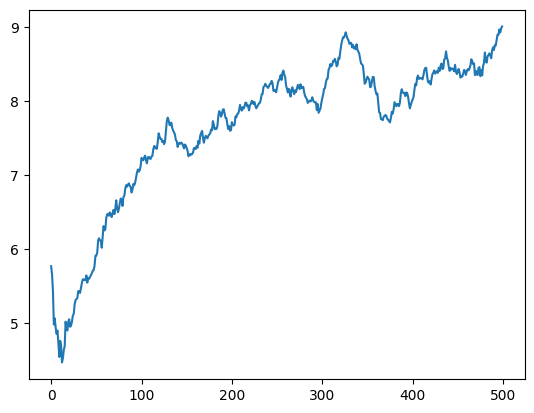

451.3950641155243


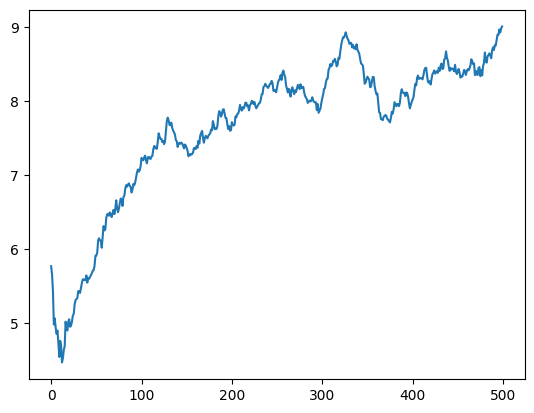

In [ ]:
fidx = 4
io_train_data = physicsio_data[iofold_list[fidx][0]]
io_test_data = physicsio_data[iofold_list[fidx][1]]

lr = 1e-2
Kval = 6
nlayers = 2
wn=[]

eta = None
use_inferred_prior = False
if use_inferred_prior:
  eta = hmc_equaltrained_thetas[fidx]
else:
  eta = np.ones(7)

nu=0.3
wn.append(np.random.rand(5,32)* nu) 
# wn.append(np.random.rand(20,20) * nu)
wn.append(np.random.rand(32,32)*nu)
muweight = np.random.rand(32,7)*nu
sigmaweight = np.random.rand(32,7)*nu




trainsetsz = len(io_train_data)
# print(iofold_list[fidx][1][0])
# print(prog, inputs)
# fw_wrap = lambda l1, l2, muweight, sigmaweight, epsilon, prog, inputs,eta, K: forward(l1,l2, muweight, sigmaweight, epsilon, prog, inputs,eta, K)
gradweight0 = grad(forward, 0)
gradweight1 = grad(forward, 1)
gradmu = grad(forward, 2)
gradsigma = grad(forward, 3)
batch_size = 32
iteration = 500
period = 2
elbo_list = []
avg_elbos = []
start_time = time.time()
for iter in range(1, iteration + 1):
  gweights0 = np.zeros(wn[0].shape)
  gweights1 = np.zeros(wn[1].shape)
  gmu = np.zeros(muweight.shape)
  gsigma = np.zeros(sigmaweight.shape)
  batch = io_train_data[random.sample(list(range(trainsetsz)), batch_size)]
  curr_elbos = 0
  for dp in batch:
    inputs = dp[:-1]
    prog = phys_compiled[int(dp[-1])]
    # nnout = nn(gweights, inputs)
    # print(dp)
    epsilon = np.random.normal(size=7)
    gweights0 += gradweight0(wn[0], wn[1], muweight, sigmaweight, epsilon, prog, inputs,eta, Kval)/ batch_size
    gweights1 += gradweight1(wn[0], wn[1], muweight, sigmaweight, epsilon, prog, inputs,eta, Kval)/ batch_size
    gmu += gradmu(wn[0], wn[1], muweight, sigmaweight, epsilon, prog, inputs,eta, Kval)/ batch_size
    # print(gmu)
    gsigma += gradsigma(wn[0], wn[1], muweight, sigmaweight, epsilon, prog, inputs,eta, Kval)/ batch_size
    delbo = forward(wn[0], wn[1], muweight, sigmaweight, epsilon, prog, inputs,eta, Kval)/ batch_size
    curr_elbos += delbo
    # print(curr_elbos)
  
  # curr_elbos = curr_elbos 
  elbo_list.append(curr_elbos)
  avg_elbos.append(sum(elbo_list[-40:]) / len(elbo_list[-40:]))
  # elbos += curr_elbos

  if(iter == 500):
    lr = lr * 0.1

  # for i, gw in enumerate(gweights):
    # wn[i] += lr * gw 
  wn[0] += lr * gweights0
  wn[1] += lr * gweights1
  muweight += lr * gmu
  
  sigmaweight += lr * gsigma
  if(iter % period == 0):
    display.clear_output(wait=True)
    print(f"Iter {iter}: curr={curr_elbos}, avg={avg_elbos[-1]}")
    print(sm(getmu(wn[0], wn[1], muweight, inputs)))
    # print(curr_elbos,np.max(gmu), np.max(gsigma), np.max(gweights[0]), np.max(gweights[1]))
    
    plt.clf()
    # plt.plot(elbo_list)
    plt.plot(avg_elbos)
    display.display(plt.gcf())
    sleep(0.001)
cvielapse = time.time() - start_time
print(cvielapse)


In [ ]:
nn0weights_short[fidx] = wn[0]
nn1weights_short[fidx] = wn[1]
muweights_short[fidx] = muweight
sigmaweights_short[fidx] = sigmaweight
print(nn0weights_short, nn1weights_short, muweights_short, sigmaweights_short)

In [ ]:
np.save("nn0weights450.npy", np.array(nn0weights_short))
np.save("nn1weights450.npy", np.array(nn1weights_short))
np.save("muweights450.npy", np.array(muweights_short))
np.save("sigmaweights450.npy", np.array(sigmaweights_short))

In [ ]:
nn0weights[fidx] = wn[0]
nn1weights[fidx] = wn[1]
muweights[fidx] = muweight
sigmaweights[fidx] = sigmaweight
print(nn0weights, nn1weights, muweights, sigmaweights)

In [ ]:
np.save("nn0weights.npy", np.array(nn0weights))
np.save("nn1weights.npy", np.array(nn1weights))
np.save("muweights.npy", np.array(muweights))
np.save("sigmaweights.npy", np.array(sigmaweights))

In [ ]:
nn0weights = np.load("nn0weights.npy")
nn1weights = np.load("nn1weights.npy")
muweights = np.load("muweights.npy")
sigmaweights = np.load("sigmaweights.npy")

In [ ]:
Kval = 6
base_theta = np.ones(7)/7.0
# base_probs = approximate_prob(phys_compiled,base_theta,True, K=Kval)
test_mh_probs = [None] * num_fold
train_mh_probs = [None] * num_fold
test_hmc_probs = [None] * num_fold
train_hmc_probs = [None] * num_fold
test_svi_probs = [None] * num_fold
train_svi_probs = [None] * num_fold
test_cvi_probs = [None] * num_fold
train_cvi_probs = [None] * num_fold

test_cvishort_probs = [None] * num_fold
train_cvishort_probs = [None] * num_fold

Kval = 6
baseline_times = []
mh_times = []
hmc_times = []
svi_times = []
cvi_times = []
cvishort_times = []

base_lls = []
mh_lls = []
hmc_lls = []
svi_lls = []
cvi_lls = []
cvishort_lls = []

mh_set = []
hmc_set = []
svi_set = []
cvi_set = []
cvishort_set = []

mh_meanset = []
hmc_meanset = []
svi_meanset = []
cvi_meanset = []
cvishort_meanset = []

for fidx in range(num_fold):

  io_train_data = physicsio_data[iofold_list[fidx][0]]
  io_test_data = physicsio_data[iofold_list[fidx][1]]
  testplist = [phys_compiled[int(dp[-1])] for dp in io_test_data]
  trainplist = [phys_compiled[int(dp[-1])] for dp in io_train_data]

  # print(f"{fidx}:{[pg.tostr() for pg in codetest_data]}")
  baseline_probs = approximate_prob(testplist, base_theta, True, K= Kval)
  base_lls.append([np.log(prob) for prob in baseline_probs])
  basetime = [int(1/prob) for prob in baseline_probs]
  baseline_times += basetime

  test_cvi_probs[fidx] = []
  muweight = muweights[fidx]
  sigmaweight = sigmaweights[fidx]
  nn0weight = nn0weights[fidx]
  nn1weight = nn1weights[fidx]
  # print(len(basetime))
  for dp in io_test_data:
    inputs = dp[:-1]
    prog = phys_compiled[int(dp[-1])]
    mu = getmu(nn0weight, nn1weight, muweight, inputs)
    cviexp_theta = sm(mu)
    # print(inputs, exp_theta)
    prob = approximate_prob([prog], cviexp_theta, True, K = Kval)[0]
    # print(prob)
    test_cvi_probs[fidx].append(prob)

  
  # print(len(test_cvi_probs[fidx]))
  cvi_lls.append([np.log(prob) for prob in test_cvi_probs[fidx]])
  cvitime = [int(1/prob) for prob in test_cvi_probs[fidx]]
  cvi_times += cvitime
  cvi_set += [sum(basetime)/sum(cvitime)]
  cvi_meanset += [mean([basetime[i]/cvitime[i] for i in range(len(basetime))])]
  
  test_cvishort_probs[fidx] = []
  muweight = muweights_short[fidx]
  sigmaweight = sigmaweights_short[fidx]
  nn0weight = nn0weights_short[fidx]
  nn1weight = nn1weights_short[fidx]
  # print(len(basetime))
  for dp in io_test_data:
    inputs = dp[:-1]
    prog = phys_compiled[int(dp[-1])]
    mu = getmu(nn0weight, nn1weight, muweight, inputs)
    cviexp_theta = sm(mu)
    # print(inputs, exp_theta)
    prob = approximate_prob([prog], cviexp_theta, True, K = Kval)[0]
    # print(prob)
    test_cvishort_probs[fidx].append(prob)
  # print(len(test_cvi_probs[fidx]))
  cvishort_lls.append([np.log(prob) for prob in test_cvishort_probs[fidx]])
  cvishorttime = [int(1/prob) for prob in test_cvishort_probs[fidx]]
  cvishort_times += cvishorttime
  cvishort_set += [sum(basetime)/sum(cvishorttime)]
  cvishort_meanset += [mean([basetime[i]/cvishorttime[i] for i in range(len(basetime))])]

  # train_mh_probs[fidx] = approximate_prob(codetrain_data, mh_equaltrained_thetas[fidx], True, K= Kval)
  test_hmc_probs[fidx] = approximate_prob(testplist, hmc_equaltrained_thetas[fidx], True, K= Kval)
  hmc_lls.append([np.log(prob) for prob in test_hmc_probs[fidx]])
  hmctime = [int(1/prob) for prob in test_hmc_probs[fidx]]
  hmc_times += hmctime
  hmc_set += [sum(basetime)/sum(hmctime)]
  hmc_meanset += [mean([basetime[i]/hmctime[i] for i in range(len(basetime))])]


hmc_speedups = []
cvi_speedups = []
cvishort_speedups = []
for i in range(len(baseline_times)):
  hmc_speedups.append(baseline_times[i] / hmc_times[i])
  cvi_speedups.append(baseline_times[i] / cvi_times[i])
  cvishort_speedups.append(baseline_times[i] / cvishort_times[i])


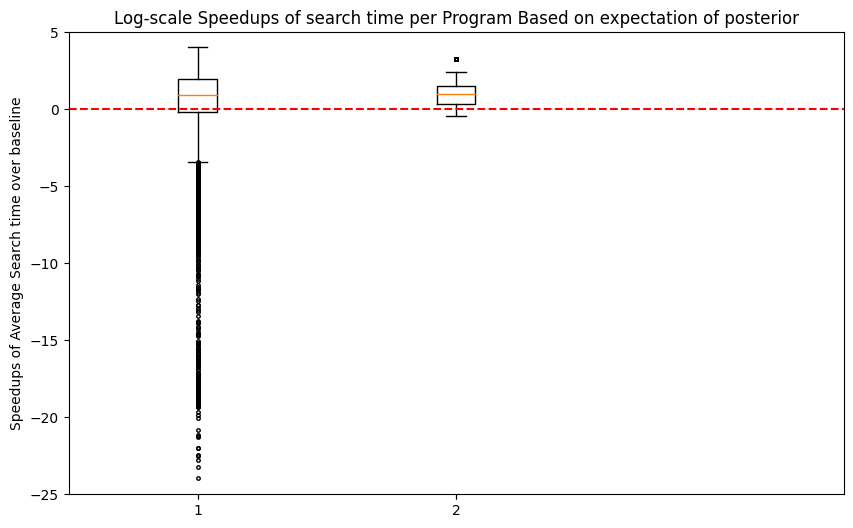

In [ ]:
space = 0
margin = 0.3
plt.figure(figsize=(10,6))
plt.title("Log-scale Speedups of search time per Program Based on expectation of posterior")
# plt.xlabel("Fold No.")
plt.ylabel("Speedups of Average Search time over baseline")
plt.xticks(np.arange(0, 5, 1.0))
plt.yticks(np.arange(-25, 5.1, 5.0))
plt.xlim([0.5,3.5])
plt.ylim([-25,5])
plt.xticks([1,2], ["CVI", "HMC"])
plt.boxplot([np.log(cvi_speedups), np.log(hmc_speedups)], flierprops={'marker': '.', 'markersize': 5, 'linewidth':1})

plt.axhline(y = 0, color = 'r', linestyle = '--')
# plt.legend(loc="upper left")

In [ ]:
baseline_times_o = baseline_times[:10*200] + baseline_times[11*200:]
cvi_times_o = cvi_times[:10*200] + cvi_times[11*200:]

In [ ]:
print(mean([baseline_times[i]/cvi_times[i] for i in range(len(baseline_times))]))
print(mean([baseline_times_o[i]/cvi_times_o[i] for i in range(len(baseline_times_o))]))
print(mean([baseline_times[i]/cvishort_times[i] for i in range(len(baseline_times))]))
print(mean([baseline_times[i]/hmc_times[i] for i in range(len(baseline_times))]))



print(sum(baseline_times) / sum(cvi_times))
print(sum(baseline_times_o) / sum(cvi_times_o))
print(sum(baseline_times) / sum(cvishort_times))
print(sum(baseline_times) / sum(hmc_times))

print(cvi_set)
print(cvishort_set)
print(hmc_set)

print(cvi_meanset)
print(cvishort_meanset)
print(hmc_meanset)

4.8451429481289665
4.963305796991647
4.779162410960496
3.802978686798641
5.221228634552245e-09
0.3305752687625065
7.889548066363108e-08
2.9104844138508303
[4.014653526735795, 2.5804774428811006e-09, 0.0011905704302820296, 0.6039866949373612, 0.6495287318054179]
[4.200818003589356, 3.899235982121856e-08, 0.0012485390740490305, 0.9759346158467707, 0.6184485634857866]
[5.213483580266951, 1.5315473451877177, 1.5174707823965718, 25.46476139531831, 11.245472975693994]
[7.919495032004844, 1.5509142417151873, 5.583307013550534, 4.21863918164088, 5.007467433534857]
[8.293684892613882, 1.3679161980676797, 5.319060849289957, 3.8704999111938516, 5.1773940999759525]
[3.6952563610835325, 2.1198742172895493, 3.6901111176636383, 5.245286648627623, 4.495058290592839]


In [ ]:
print(sum(physicsio_data_combined[iofold_list_multi[4][0]][:,-1] == physicsio_data[iofold_list[4][0]][::8,-1]))

900


In [ ]:
nn0weights_multi = [None] * num_fold
nn1weights_multi = [None] * num_fold
muweights_multi = [None] * num_fold
sigmaweights_multi = [None] * num_fold

Iter 800: curr=12.212571631331294, avg=10.05177411694675
[5.55558621e-01 8.63805241e-02 6.36127395e-04 6.02149681e-17
 3.20408424e-01 1.28567541e-02 2.41595490e-02]


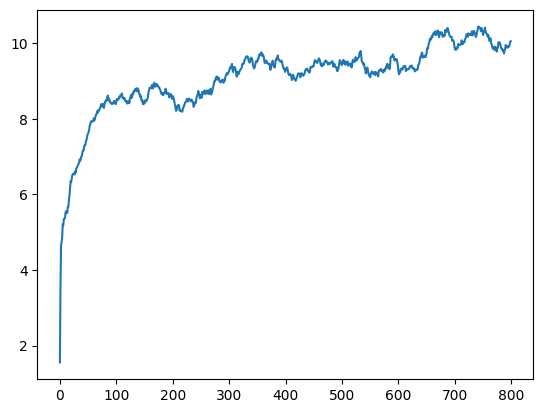

833.4696197509766


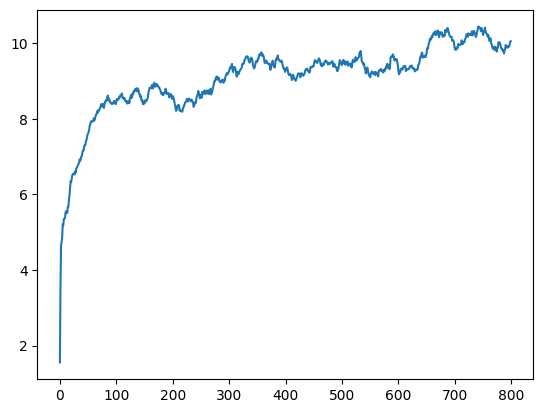

In [95]:
fidx = 3
io_train_data = physicsio_data_combined[iofold_list_multi[fidx][0]]
io_test_data = physicsio_data_combined[iofold_list_multi[fidx][1]]

lr = 1e-2
Kval = 6
nlayers = 2
wn=[]

eta = None
use_inferred_prior = False
if use_inferred_prior:
  eta = hmc_equaltrained_thetas[fidx]
else:
  eta = np.ones(7)

nu=0.1
wn.append(np.random.rand(40,64)* nu) 
# wn.append(np.random.rand(20,20) * nu)
wn.append(np.random.rand(64,64)*nu)
muweight = np.random.rand(64,7)*nu
sigmaweight = np.random.rand(64,7)*nu




trainsetsz = len(io_train_data)
# print(iofold_list[fidx][1][0])
# print(prog, inputs)
# fw_wrap = lambda l1, l2, muweight, sigmaweight, epsilon, prog, inputs,eta, K: forward(l1,l2, muweight, sigmaweight, epsilon, prog, inputs,eta, K)
gradweight0 = grad(forward, 0)
gradweight1 = grad(forward, 1)
gradmu = grad(forward, 2)
gradsigma = grad(forward, 3)
batch_size = 32
iteration = 800
period = 2
elbo_list = []
avg_elbos = []
start_time = time.time()
for iter in range(1, iteration + 1):
  gweights0 = np.zeros(wn[0].shape)
  gweights1 = np.zeros(wn[1].shape)
  gmu = np.zeros(muweight.shape)
  gsigma = np.zeros(sigmaweight.shape)
  batch = io_train_data[random.sample(list(range(trainsetsz)), batch_size)]
  curr_elbos = 0
  for dp in batch:
    inputs = dp[:-1]
    prog = phys_compiled[int(dp[-1])]
    # nnout = nn(gweights, inputs)
    # print(dp)
    epsilon = np.random.normal(size=7)
    gweights0 += gradweight0(wn[0], wn[1], muweight, sigmaweight, epsilon, prog, inputs,eta, Kval)/ batch_size
    # print(gweights0.shape)
    gweights1 += gradweight1(wn[0], wn[1], muweight, sigmaweight, epsilon, prog, inputs,eta, Kval)/ batch_size
    gmu += gradmu(wn[0], wn[1], muweight, sigmaweight, epsilon, prog, inputs,eta, Kval)/ batch_size
    # print(gmu)
    gsigma += gradsigma(wn[0], wn[1], muweight, sigmaweight, epsilon, prog, inputs,eta, Kval)/ batch_size
    delbo = forward(wn[0], wn[1], muweight, sigmaweight, epsilon, prog, inputs,eta, Kval)/ batch_size
    curr_elbos += delbo
    # print(curr_elbos)
  
  # curr_elbos = curr_elbos 
  elbo_list.append(curr_elbos)
  avg_elbos.append(sum(elbo_list[-40:]) / len(elbo_list[-40:]))
  # elbos += curr_elbos

  if(iter == 500):
    lr = lr * 0.1

  # for i, gw in enumerate(gweights):
    # wn[i] += lr * gw 
  wn[0] += lr * gweights0
  wn[1] += lr * gweights1
  muweight += lr * gmu
  
  sigmaweight += lr * gsigma
  if(iter % period == 0):
    display.clear_output(wait=True)
    print(f"Iter {iter}: curr={curr_elbos}, avg={avg_elbos[-1]}")
    print(sm(getmu(wn[0], wn[1], muweight, inputs)))
    # print(curr_elbos,np.max(gmu), np.max(gsigma), np.max(gweights[0]), np.max(gweights[1]))
    
    plt.clf()
    # plt.plot(elbo_list)
    plt.plot(avg_elbos)
    display.display(plt.gcf())
    sleep(0.001)
cvielapse = time.time() - start_time
print(cvielapse)


In [96]:
nn0weights_multi[fidx] = wn[0]
nn1weights_multi[fidx] = wn[1]
muweights_multi[fidx] = muweight
sigmaweights_multi[fidx] = sigmaweight
print(nn0weights_multi[fidx].shape)

(40, 64)


In [86]:
np.save("nn0weights_multi.npy", np.array(nn0weights_multi))
np.save("nn1weights_multi.npy", np.array(nn1weights_multi))
np.save("muweights_multi.npy", np.array(muweights_multi))
np.save("sigmaweights_multi.npy", np.array(sigmaweights_multi))

In [99]:
Kval = 6
base_theta = np.ones(7)/7.0

test_hmc_probs = [None] * num_fold
train_hmc_probs = [None] * num_fold

test_cvi_probs = [None] * num_fold
train_cvi_probs = [None] * num_fold


Kval = 6
baseline_times = []
hmc_times = []
cvi_times = []


base_lls = []
hmc_lls = []
cvi_lls = []


hmc_set = []
cvi_set = []

hmc_meanset = []
cvi_meanset = []

for fidx in range(num_fold):
  io_train_data = physicsio_data_combined[iofold_list_multi[fidx][0]]
  io_test_data = physicsio_data_combined[iofold_list_multi[fidx][1]]
  testplist = [phys_compiled[int(dp[-1])] for dp in io_test_data]
  trainplist = [phys_compiled[int(dp[-1])] for dp in io_train_data]

  # print(f"{fidx}:{[pg.tostr() for pg in codetest_data]}")
  baseline_probs = approximate_prob(testplist, base_theta, True, K= Kval)
  base_lls.append([np.log(prob) for prob in baseline_probs])
  basetime = [int(1/prob) for prob in baseline_probs]
  baseline_times += basetime

  test_cvi_probs[fidx] = []
  muweight = muweights_multi[fidx]
  sigmaweight = sigmaweights_multi[fidx]
  nn0weight = nn0weights_multi[fidx]
  nn1weight = nn1weights_multi[fidx]
  # print(io_test_data.shape)
  for dp in io_test_data:
    inputs = dp[:-1]
    prog = phys_compiled[int(dp[-1])]
    mu = getmu(nn0weight, nn1weight, muweight, inputs)
    cviexp_theta = sm(mu)
    # print(inputs, exp_theta)
    prob = approximate_prob([prog], cviexp_theta, True, K = Kval)[0]
    # print(prob)
    test_cvi_probs[fidx].append(prob)

  
  # print(len(test_cvi_probs[fidx]))
  print(test_cvi_probs[fidx])
  cvi_lls.append([np.log(prob) for prob in test_cvi_probs[fidx]])
  cvitime = [int(1/prob) for prob in test_cvi_probs[fidx]]
  cvi_times += cvitime
  cvi_set += [sum(basetime)/sum(cvitime)]
  cvi_meanset += [mean([basetime[i]/cvitime[i] for i in range(len(basetime))])]


  # train_mh_probs[fidx] = approximate_prob(codetrain_data, mh_equaltrained_thetas[fidx], True, K= Kval)
  test_hmc_probs[fidx] = approximate_prob(testplist, hmc_equaltrained_thetas[fidx], True, K= Kval)
  hmc_lls.append([np.log(prob) for prob in test_hmc_probs[fidx]])
  hmctime = [int(1/prob) for prob in test_hmc_probs[fidx]]
  hmc_times += hmctime
  hmc_set += [sum(basetime)/sum(hmctime)]
  hmc_meanset += [mean([basetime[i]/hmctime[i] for i in range(len(basetime))])]

hmc_speedups = []
cvi_speedups = []
for i in range(len(baseline_times)):
  hmc_speedups.append(baseline_times[i] / hmc_times[i])
  cvi_speedups.append(baseline_times[i] / cvi_times[i])

[0.026315584037423314, 0.02478258465229664, 0.03148235642197283, 0.027869140341205724, 0.02323567398523855, 0.029313565661129713, 0.02163390296005101, 0.025847045372228105, 0.0328469008372584, 0.0256075696116807, 0.02258991086029954, 0.03294520845567398, 0.022708202276598657, 0.02462463540176816, 0.020535165804131172, 0.016507472980275408, 0.02565858803693104, 0.025961054920686764, 0.017651618226455872, 0.025457757808161827, 0.01653118886178026, 0.031087490831379072, 0.030201682009164305, 0.0241974758356119, 0.02134576133227816, 0.04294299985538461, 0.0318637559061274, 0.05793135010099614, 0.06491462599802363, 0.023053387441737464, 0.03730742749996379, 0.02628616625176592, 0.0325956346829115, 0.06142866978933959, 0.03408323668547404, 0.0356933268727239, 0.04619814984084991, 0.0453881055335528, 0.036546785110885036, 0.04117901418089609, 0.040632244289335706, 0.0616304691230807, 0.06330524481720362, 0.032547917897680405, 0.03527906200232774, 0.0368839728267719, 0.054178358636524135, 0.04

In [101]:
baseline_times_o = baseline_times[:10*25] + baseline_times[11*25:]
cvi_times_o = cvi_times[:10*25] + cvi_times[11*25:]

In [102]:
print(mean([baseline_times[i]/cvi_times[i] for i in range(len(baseline_times))]))
print(mean([baseline_times_o[i]/cvi_times_o[i] for i in range(len(baseline_times_o))]))
# print(mean([baseline_times[i]/cvishort_times[i] for i in range(len(baseline_times))]))
print(mean([baseline_times[i]/hmc_times[i] for i in range(len(baseline_times))]))



print(sum(baseline_times) / sum(cvi_times))
print(sum(baseline_times_o) / sum(cvi_times_o))
print(sum(baseline_times) / sum(hmc_times))

print(cvi_set)
# print(cvishort_set)
print(hmc_set)

print(cvi_meanset)
# print(cvishort_meanset)
print(hmc_meanset)

4.9837007589713105
5.104550972981587
3.8029786867985917
1.4184344145419835e-06
0.00507200728831272
2.9104844138508303
[2.4854448876231694, 7.011291851167e-07, 1.1025465532329896e-05, 0.020067067411313682, 4.7820855034267655]
[5.213483580266951, 1.5315473451877177, 1.5174707823965718, 25.46476139531831, 11.245472975693994]
[7.331710176160325, 1.8799171430787747, 6.008944690766034, 4.777867791388969, 4.888245610707907]
[3.695256361083622, 2.1198742172895617, 3.690111117663696, 5.245286648627796, 4.495058290592892]
